# Import library

In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# RMSE

In [6]:
def rmse(pred, actual):
    '''
    params:
        pred <np.array>: an array containing all predicted ratings
        actual <np.array>: an array containing all ground truth ratings

    return:
        a scalar whose value is the rmse
    '''
    # Ignore ratings with value zero.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return np.sqrt(mean_squared_error(pred, actual))

# Loading Data

In [7]:
review_df = pd.read_csv("data/review.csv")
valid_df = pd.read_csv("data/validation.csv")
prediction_df = pd.read_csv("data/prediction.csv")
product_df = pd.read_json("data/product.json")

In [8]:
review_df.head()

,ReviewerID,ProductID,Text,Summary,Star
0,A1K4S4MWXI9E9M,B000FC27TA,Purchased more out of curiosity than any real ...,"Not my favorite, but...",3.0
1,A3LF914GG87TWP,B000FC27TA,"I actually received this text as an ebook, sin...",An interesting read,4.0
2,A1CNQTCRQ35IMM,B000FCKPG2,REVIEWER'S OPINION:\nThis was labeled as roman...,This was labeled romance but there was less ro...,2.0
3,ACVNKHUOX3QWU,B000GCFWXW,I liked this story although its probably not o...,Different,4.0
4,AU510CVD9XDG,B000GCFWXW,I have been saving the Argeneau novels for awh...,Science Fiction not Paranormal Romance,2.0


In [9]:
valid_df.head()

,ReviewerID,ProductID,Star
0,A3CMIEYL0TJLC2,B01DCM610A,5.0
1,AC97LVZ0C0TSK,B00TIUEVL2,5.0
2,A2X6LA6IS2C32K,B00DLSTT9Q,5.0
3,A5KRI5P7KR7SK,B018RFX3I0,4.0
4,A244C0ORREA3N5,B00UXLO4N0,5.0


In [10]:
prediction_df.head()

,ReviewerID,ProductID,Star
0,A369BMHORFPL0O,B018A8EDV0,0
1,A24ETSYVDJB5D3,B016VIVLJ8,0
2,A2HX0B5ELOPP5Z,B01GYPPMNE,0
3,A244C0ORREA3N5,B014BR4A3A,0
4,A2B9C3FMYW18UN,B0134EZGY8,0


In [11]:
product_df.head()

,category,tech1,description,fit,title,tech2,brand,feature,rank,details,main_cat,similar_item,date,price,imageURL,imageURLHighRes,ProductID
0,"[Kindle Store, Kindle eBooks, Science Fiction ...",,[],,,,Visit Amazon's Elizabeth Moon Page,[],"88,963 Paid in Kindle Store (","{'File Size:': '2199 KB', 'Print Length:': '31...",Buy a Kindle,,NaT,,[],[],B000FBJBA4
1,"[Kindle Store, Kindle eBooks, Politics & Socia...",,[],,,,Visit Amazon's Karl Marx Page,[],"1,358,073 Paid in Kindle Store (","{'File Size:': '142 KB', 'Print Length:': '160...",Buy a Kindle,,NaT,,[],[],B000FC27TA
2,"[Kindle Store, Kindle eBooks, Romance]",,[],,,,Visit Amazon's Allison Brennan Page,[],"94,006 Paid in Kindle Store (","{'File Size:': '739 KB', 'Print Length:': '416...",Buy a Kindle,,NaT,,[],[],B000FCKPG2
3,"[Kindle Store, Kindle eBooks, Mystery, Thrille...",,[],,,,Visit Amazon's Lynsay Sands Page,[],"31,652 Paid in Kindle Store (","{'File Size:': '1011 KB', 'Print Length:': '38...",Buy a Kindle,,NaT,,[],[],B000GCFWXW
4,"[Kindle Store, Kindle eBooks, Romance]",,[],,,,Visit Amazon's Fern Michaels Page,[],"1,031,468 Paid in Kindle Store (","{'File Size:': '519 KB', 'Print Length:': '320...",Buy a Kindle,,NaT,,[],[],B000JMKRTI


# Neural Collaborative Filtering (NCF) Model Implementation

Here we implement two instantiations of NCF model. 

The first instantiation computes the recommendation score (e.g., ratings) between a pair of user and item using dot product of their embeddings, which is equivalent to matrix factorization model for recommendation.

The second instantiation concatenates the user's and item's embeddings, then feed the the concatenated vector into a MLP to calculate the recommendation score. Adoption of MLP equips the model with high flexibility and non-linearity to effectively learn the interaction between user and item latent features.

In [27]:
reviewer_set = set(review_df.ReviewerID.unique())
product_set = set(review_df.ProductID.unique())

reviewer_vocab = dict(zip(reviewer_set, range(1, len(reviewer_set) + 1)))
reviewer_vocab['unk'] = 0
n_reviewers = len(reviewer_vocab)

product_vocab = dict(zip(product_set, range(1, len(product_set) + 1)))
product_vocab['unk'] = 0
n_products = len(product_vocab)

In [28]:
train_reviewers = review_df.ReviewerID.apply(lambda x: reviewer_vocab[x]).values
train_products = review_df.ProductID.apply(lambda x: product_vocab[x]).values
valid_reviewers = valid_df.ReviewerID.apply(lambda x: reviewer_vocab[x] if x in reviewer_vocab else 0).values
valid_products = valid_df.ProductID.apply(lambda x: product_vocab[x] if x in product_vocab else 0).values

train_ratings = np.asarray(review_df.Star)
valid_ratings = np.asarray(valid_df.Star)

In [10]:
print(type(train_reviewers))
print(type(train_products))
print(type(valid_reviewers))
print(type(valid_products))

print(type(train_ratings))
print(type(valid_ratings))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## Model

In [203]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Concatenate, Dense, Dropout, Embedding, Flatten, Multiply, Input, BatchNormalization, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

In [204]:
def build_ncf_model(n_reviewers, n_products, embed_size, output_layer='dot'):
    '''
    params:
        n_users <int>: The number of user embedding vectors
        n_items <int>: The number of item embedding vectors
        embed_size <int>: The dimension of each embedding vector
        output_layer <str>: Indicates the instantiation of NCF to use, available options are either 'dot' or 'mlp'

    return:
        a keras Model object for the constructed ncf model 
    '''
    # Get the users and items input
    reviewer_input = Input(shape=(1,), dtype='int32', name='reviewer_input')
    product_input = Input(shape=(1,), dtype='int32', name='product_input')


    # Get the embeddings of users and items
    reviewer_emb = Embedding(output_dim=embed_size, input_dim=n_reviewers, input_shape=1)(reviewer_input)
    reviewer_emb = Reshape((embed_size,))(reviewer_emb)
    product_emb = Embedding(output_dim=embed_size, input_dim=n_products, input_shape=1)(product_input)
    product_emb = Reshape((embed_size,))(reviewer_emb)


    if output_layer == 'dot':
        # Compute the dot product of users' and items' embeddings as the model output
        model_output = Dot(axes=1)([reviewer_emb, product_emb])

    elif output_layer == 'mlp':
        # Concatenate the users' and items' embeddings as the input of MLP
        mlp_input = Concatenate()([reviewer_emb, product_emb])

        # First fully-connected layer
        dense_1 = Dense(64, activation='relu')(mlp_input)
        dense_1_dp = Dropout(0.15)(dense_1)

        # Second fully-connected layer
        dense_2 = Dense(32, activation='relu')(dense_1_dp)
        dense_2_dp = Dropout(0.15)(dense_2)

        # Final fully-connected layer to compute model output
        model_output = Dense(1)(dense_2_dp)
    else:
        raise NotImplementedError

    model = Model(inputs=[reviewer_input, product_input], outputs=model_output)
    return model

In [205]:
model = build_ncf_model(n_reviewers, n_products, embed_size=50, output_layer='mlp')

In [206]:
model.compile(optimizer='adam', loss='mse')

history = model.fit(
        x=[train_reviewers, train_products], 
        y=train_ratings, 
        validation_data=([valid_reviewers, valid_products], valid_ratings),
        epochs=20, 
        verbose=1,
        callbacks=[ModelCheckpoint('models/ncf_model_eval.keras')])

Epoch 1/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 2s 911us/step - loss: 3.4930 - val_loss: 0.7672
Epoch 2/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 1s 831us/step - loss: 0.7662 - val_loss: 0.7326
Epoch 3/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 1s 862us/step - loss: 0.7197 - val_loss: 0.7140
Epoch 4/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 1s 844us/step - loss: 0.6845 - val_loss: 0.7415
Epoch 5/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 1s 825us/step - loss: 0.6410 - val_loss: 0.7148
Epoch 6/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 1s 820us/step - loss: 0.6224 - val_loss: 0.7190
Epoch 7/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 1s 829us/step - loss: 0.6122 - val_loss: 0.7139
Epoch 8/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step - loss: 0.5891 - val_loss: 0.7185
Epoch 9/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 1s 831us/step - loss: 0.5736 - val_loss: 0.7200
Epoch 10/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 1s 824us/step - loss: 0.5720 - val_loss: 0.7119
Epoch 11/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 1s 834us/step - loss: 0.5641 - val_loss: 0.7265
Epoch 12

In [227]:
model = tf.keras.models.load_model('models/ncf_model_eval.keras')
y_pred = model.predict([train_reviewers, train_products])
print("Train set RMSE: ", rmse(y_pred, train_ratings))
y_pred = model.predict([valid_reviewers, valid_products])
print("Validation set RMSE: ", rmse(y_pred, valid_ratings))

1647/1647 ━━━━━━━━━━━━━━━━━━━━ 1s 430us/step
Train set RMSE:  0.7187089770880871
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step
Validation set RMSE:  0.8521158953880907


# Building NeuMF model

## Importing library

In [209]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Concatenate, Dense, Dropout, Embedding, Flatten, Multiply, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

## Model

In [210]:
def build_NeuMF_model(n_reviewers, n_products, gmf_dim, gmf_regularizer=0, mlp_layers=[32], mlp_regularizer_layers=0, mlp_dropout=0.2):    
    # Get the users and items input

    reviewers_input = Input(shape=(1,), dtype='int32', name='reviewers_input')
    products_input = Input(shape=(1,), dtype='int32', name='products_input')

    # Get the embeddings of users and items
    gmf_reviewers_emb = Embedding(input_dim=n_reviewers, output_dim=gmf_dim, embeddings_initializer='uniform',
                            embeddings_regularizer=l2(gmf_regularizer), name='gmf_reviwers_embedding',input_shape=1)
    gmf_products_emb = Embedding(input_dim=n_products, output_dim=gmf_dim, embeddings_initializer='uniform',
                            embeddings_regularizer=l2(gmf_regularizer), name='gmf_products_embedding',input_shape=1)
    mlp_reviewers_emb = Embedding(input_dim=n_reviewers, output_dim=int(mlp_layers[0]/2), embeddings_initializer='uniform',
                            embeddings_regularizer=l2(mlp_regularizer_layers), name='mlp_reviwers_embedding',input_shape=1)
    mlp_products_emb = Embedding(input_dim=n_products, output_dim=int(mlp_layers[0]/2), embeddings_initializer='uniform',
                            embeddings_regularizer=l2(mlp_regularizer_layers), name='mlp_products_embedding',input_shape=1)

    # GMF
    gmf_reviwers_latent = Flatten()(gmf_reviewers_emb(reviewers_input))
    gmf_products_latent = Flatten()(gmf_products_emb(products_input))
    gmf_vector = Multiply()([gmf_reviwers_latent, gmf_products_latent])

    # MLP
    mlp_reviwers_latent = Flatten()(mlp_reviewers_emb(reviewers_input))
    mlp_products_latent = Flatten()(mlp_products_emb(products_input))
    mlp_vector = Concatenate()([mlp_reviwers_latent, mlp_products_latent])
    mlp_vector = Dropout(mlp_dropout)(mlp_vector)
    for index in range(len(mlp_layers)):
        layer = Dense(mlp_layers[index], kernel_regularizer=l2(mlp_regularizer_layers),
                        activation='relu', name="layer%d" %index)
        mlp_vector = layer(mlp_vector)
        # if (index < 2):
            # mlp_vector = BatchNormalization()(mlp_vector)
            # mlp_vector = Dropout(mlp_dropout)(mlp_vector)
    
    predict_vector = Concatenate()([gmf_vector, mlp_vector])
    prediction = Dense(1, kernel_initializer='lecun_uniform', name="prediction")(predict_vector)

    model = Model(inputs=[reviewers_input, products_input], outputs=prediction)

    return model

In [213]:
n_reviewers, n_products, gmf_dim, gmf_regularizer, mlp_layers, mlp_regularizer_layers, mlp_dropout = n_reviewers, n_products, 56, 0.001, [32, 16, 8], 0.001, 0.2
model = build_NeuMF_model(n_reviewers, n_products, gmf_dim, gmf_regularizer, mlp_layers, mlp_regularizer_layers, mlp_dropout)

In [214]:
model.compile(optimizer='adam', loss='mse')

history = model.fit(
        x=[train_reviewers, train_products], 
        y=train_ratings, 
        batch_size=32,
        validation_data=([valid_reviewers, valid_products], valid_ratings),
        epochs=20, 
        verbose=1,
        callbacks=[ModelCheckpoint('models/neumf_model_eval.keras')])

Epoch 1/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 5.0168 - val_loss: 0.8081
Epoch 2/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6364 - val_loss: 0.8080
Epoch 3/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6093 - val_loss: 0.8073
Epoch 4/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6091 - val_loss: 0.8240
Epoch 5/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6016 - val_loss: 0.8063
Epoch 6/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.5926 - val_loss: 0.8141
Epoch 7/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.5982 - val_loss: 0.7956
Epoch 8/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.5928 - val_loss: 0.7977
Epoch 9/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.5828 - val_loss: 0.7971
Epoch 10/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.5865 - val_loss: 0.8086
Epoch 11/20
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.5739 - val_loss: 0.7912
Epoch 12/20
1647/1647 ━━━━━━━━

In [215]:
model = tf.keras.models.load_model('models/neumf_model_eval.keras')
y_pred = model.predict([train_reviewers, train_products])
print("Train set RMSE: ", rmse(y_pred, train_ratings))
y_pred = model.predict([valid_reviewers, valid_products])
print("Validation set RMSE: ", rmse(y_pred, valid_ratings))

1647/1647 ━━━━━━━━━━━━━━━━━━━━ 1s 356us/step
Train set RMSE:  0.6629437474106505
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
Validation set RMSE:  0.8386133326074092


# Tuning model

## Trying model's limitation

In [198]:
rmse_i = 0.84
target_rmse = 0.832
while (rmse_i > target_rmse):
    n_reviewers, n_products, gmf_dim, gmf_regularizer, mlp_layers, mlp_regularizer_layers, mlp_dropout = n_reviewers, n_products, 56, 0.001, [32, 16, 8], 0.001, 0.2
    model = build_NeuMF_model(n_reviewers, n_products, gmf_dim, gmf_regularizer, mlp_layers, mlp_regularizer_layers, mlp_dropout)

    model.compile(optimizer='adam', loss='mse')

    history = model.fit(
            x=[train_reviewers, train_products], 
            y=train_ratings, 
            batch_size=32,
            validation_data=([valid_reviewers, valid_products], valid_ratings),
            epochs=3, 
            verbose=1,
            callbacks=[ModelCheckpoint('models/model.keras')])
    model = tf.keras.models.load_model('models/model.keras')
    # y_pred = model.predict([train_reviewers, train_products])
    # print("Train set RMSE: ", rmse(y_pred, train_ratings))
    y_pred = model.predict([valid_reviewers, valid_products])
    rmse_i = rmse(y_pred, valid_ratings)
    print("Validation set RMSE: ", rmse_i)

Epoch 1/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 5.8804 - val_loss: 0.8267
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6372 - val_loss: 0.8111
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6198 - val_loss: 0.7956
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step
Validation set RMSE:  0.8355031389402109
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 4.7461 - val_loss: 0.8196
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6247 - val_loss: 0.8004
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6172 - val_loss: 0.8320
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
Validation set RMSE:  0.8583270856900971
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 5.4370 - val_loss: 0.8147
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6155 - val_loss: 0.7972
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6145 - val_loss: 0.8119
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
Validation set RMSE:  0.8482232463446921
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 4.3983 - val_loss: 0.8017
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6321 - val_loss: 0.8093
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6194 - val_loss: 0.8043
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step
Validation set RMSE:  0.842033256232819
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 4.4148 - val_loss: 0.8113
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6194 - val_loss: 0.8030
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6111 - val_loss: 0.8193
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
Validation set RMSE:  0.8508042207259933
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 4.1811 - val_loss: 0.8711
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6316 - val_loss: 0.8151
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6235 - val_loss: 0.8285
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step
Validation set RMSE:  0.8541372771247535
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 4.5426 - val_loss: 0.8138
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6341 - val_loss: 0.8282
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6124 - val_loss: 0.7982
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
Validation set RMSE:  0.8392847676419654
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 4.6191 - val_loss: 0.8098
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6273 - val_loss: 0.7949
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6152 - val_loss: 0.8151
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
Validation set RMSE:  0.846390813041836
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 4.6998 - val_loss: 0.8219
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6310 - val_loss: 0.8094
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6133 - val_loss: 0.8039
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
Validation set RMSE:  0.8439891775769714
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 4.5564 - val_loss: 0.8046
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6209 - val_loss: 0.7998
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6108 - val_loss: 0.8072
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
Validation set RMSE:  0.846827905981522
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 5.0182 - val_loss: 0.8159
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6279 - val_loss: 0.8103
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6023 - val_loss: 0.8096
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step
Validation set RMSE:  0.8435624205313097
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 4.8158 - val_loss: 0.8139
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6312 - val_loss: 0.8028
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6148 - val_loss: 0.8065
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
Validation set RMSE:  0.8424996538627565
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 4.7672 - val_loss: 0.8323
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6158 - val_loss: 0.8058
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6221 - val_loss: 0.8055
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step
Validation set RMSE:  0.8448087358642896
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 4.5639 - val_loss: 0.8165
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6223 - val_loss: 0.8105
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6147 - val_loss: 0.8153
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step
Validation set RMSE:  0.8493900206194563
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 4.4459 - val_loss: 0.8206
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6427 - val_loss: 0.8114
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6026 - val_loss: 0.8035
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step
Validation set RMSE:  0.8383589357003614
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 4.7856 - val_loss: 0.8143
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6274 - val_loss: 0.8051
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6132 - val_loss: 0.8041
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
Validation set RMSE:  0.8428654647909936
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   1/1647 ━━━━━━━━━━━━━━━━━━━━ 27:24 999ms/step - loss: 21.2014

2024-05-26 14:45:46.605898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Shapes of all inputs must match: values[0].shape = [0] != values[1].shape = []
	 [[{{function_node __inference_one_step_on_data_7588702}}{{node packed}}]]


InvalidArgumentError: Graph execution error:

Detected at node packed defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/var/folders/7k/cc6zkc6561384xnjx3rtpj6w0000gn/T/ipykernel_71378/3640063594.py", line 9, in <module>

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 325, in fit

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 118, in one_step_on_iterator

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 106, in one_step_on_data

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 60, in train_step

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/trainers/trainer.py", line 336, in compute_loss

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/ops/numpy.py", line 5938, in sum

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/backend/tensorflow/numpy.py", line 1961, in sum

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/backend/tensorflow/core.py", line 114, in convert_to_tensor

Shapes of all inputs must match: values[0].shape = [0] != values[1].shape = []
	 [[{{node packed}}]] [Op:__inference_one_step_on_iterator_7588787]

## Tuning model hyperparameters

In [106]:
gmf_regularizer, mlp_regularizer_layers = 0.001, 0.001
gmf_dim_list = [i for i in range(32, 65, 2)]
mlp_layers_list = [[128, 64], [128, 64, 32], [128, 64, 32, 16], 
                    [64, 32], [64, 32, 16], [64, 32, 16, 8],
                    [32, 16], [32, 16, 8], [32, 16, 8, 4],
                    [16, 8], [16, 8, 4], [16, 8, 4, 2]]
mlp_dropout_list = [0.1, 0.15, 0.2, 0.25, 0.3]
batch_size_list = [i for i in range(8, 33, 4)]
best_parameters = [0, 0, 0, 0]
best_rmse = 10

for gmf_dim in gmf_dim_list:
    for mlp_layers in mlp_layers_list:
        for mlp_dropout in mlp_dropout_list:
            for batch_size in batch_size_list:
                print("gmf_dim, mlp_layers, mlp_dropout, batch_size = %i, %s, %.2f, %i" %(gmf_dim, mlp_layers, mlp_dropout, batch_size))
                model = build_NeuMF_model(n_reviewers, n_products, gmf_dim, gmf_regularizer, mlp_layers, mlp_regularizer_layers, mlp_dropout)
                model.compile(optimizer='adam', loss='mse')
                history = model.fit(
                        x=[train_reviewers, train_products], 
                        y=train_ratings, 
                        batch_size=batch_size,
                        validation_data=([valid_reviewers, valid_products], valid_ratings),
                        epochs=3, 
                        verbose=1)
                
                # y_pred = history.predict([train_reviewers, train_products])
                # current_rmse = rmse(y_pred, train_ratings)
                # print("Train set RMSE: ", current_rmse)
                y_pred = model.predict([valid_reviewers, valid_products])
                current_rmse = rmse(y_pred, valid_ratings)
                # print("Validation set RMSE: ", current_rmse)
                if (current_rmse < best_rmse):
                    best_rmse = current_rmse
                    best_parameters = gmf_dim, mlp_layers, mlp_dropout, batch_size
print("best_rmse = ", best_rmse)
print("best_parameters = ", best_parameters)

gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.10, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 1.8037 - val_loss: 0.9432
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 0.7999 - val_loss: 0.8783
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 0.7531 - val_loss: 0.8593
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.10, 12
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4392/4392 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 1.9284 - val_loss: 0.9142
Epoch 2/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.7794 - val_loss: 0.8846
Epoch 3/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.7282 - val_loss: 0.8666
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.10, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 2.1859 - val_loss: 0.9001
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.7983 - val_loss: 0.8479
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.7283 - val_loss: 0.8439
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.10, 20
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2635/2635 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 2.3695 - val_loss: 0.8923
Epoch 2/3
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.7836 - val_loss: 0.8251
Epoch 3/3
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.7149 - val_loss: 0.8337
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 2.6623 - val_loss: 0.9264
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.7752 - val_loss: 0.8630
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.7069 - val_loss: 0.8238
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.10, 28
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1883/1883 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 3.0118 - val_loss: 0.9061
Epoch 2/3
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.7783 - val_loss: 0.8373
Epoch 3/3
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.7089 - val_loss: 0.8236
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 3.1553 - val_loss: 0.9048
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7780 - val_loss: 0.8583
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7115 - val_loss: 0.8306
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.15, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 1.8282 - val_loss: 0.9055
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 0.8424 - val_loss: 0.8842
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 0.7929 - val_loss: 0.8836
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.15, 12
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4392/4392 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 2.0147 - val_loss: 0.9149
Epoch 2/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.8165 - val_loss: 0.8586
Epoch 3/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.7685 - val_loss: 0.8526
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.15, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 2.2718 - val_loss: 0.9130
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.8259 - val_loss: 0.8618
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.7488 - val_loss: 0.8566
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.15, 20
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2635/2635 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 2.5563 - val_loss: 0.9329
Epoch 2/3
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.8681 - val_loss: 0.8629
Epoch 3/3
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.7632 - val_loss: 0.8306
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.15, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 2.8005 - val_loss: 0.9279
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.8370 - val_loss: 0.8684
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.7651 - val_loss: 0.8501
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.15, 28
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1883/1883 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 3.0249 - val_loss: 0.9102
Epoch 2/3
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.8197 - val_loss: 0.8577
Epoch 3/3
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.7541 - val_loss: 0.8265
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.15, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 3.4372 - val_loss: 0.9448
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.8362 - val_loss: 0.8574
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7860 - val_loss: 0.8512
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.20, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 1.8851 - val_loss: 0.9238
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 0.8659 - val_loss: 0.8789
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 0.7976 - val_loss: 0.9250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.20, 12
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4392/4392 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 2.1673 - val_loss: 0.9479
Epoch 2/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.8947 - val_loss: 0.8723
Epoch 3/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.8041 - val_loss: 0.8728
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.20, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 2.3797 - val_loss: 0.9672
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.8853 - val_loss: 0.8742
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.8049 - val_loss: 0.8607
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.20, 20
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2635/2635 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 2.5850 - val_loss: 0.9460
Epoch 2/3
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.8643 - val_loss: 0.8662
Epoch 3/3
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.7900 - val_loss: 0.8572
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 2.7783 - val_loss: 0.9645
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.8739 - val_loss: 0.8651
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.7851 - val_loss: 0.8543
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.20, 28
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1883/1883 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 3.0365 - val_loss: 0.9266
Epoch 2/3
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.8842 - val_loss: 0.8715
Epoch 3/3
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.8070 - val_loss: 0.8353
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 3.2540 - val_loss: 0.9128
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.8913 - val_loss: 0.8652
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.7860 - val_loss: 0.8293
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.25, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 1.9854 - val_loss: 0.9322
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 0.9053 - val_loss: 0.9023
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 0.8367 - val_loss: 0.8730
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.25, 12
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4392/4392 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 2.1469 - val_loss: 0.9242
Epoch 2/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.9128 - val_loss: 0.8836
Epoch 3/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.8339 - val_loss: 0.8826
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.25, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 2.4322 - val_loss: 0.9369
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.9254 - val_loss: 0.8804
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.8338 - val_loss: 0.8780
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.25, 20
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2635/2635 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 2.7166 - val_loss: 0.9354
Epoch 2/3
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.9344 - val_loss: 0.8697
Epoch 3/3
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.8309 - val_loss: 0.8580
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.25, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 2.8876 - val_loss: 0.9436
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.9184 - val_loss: 0.8699
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.8326 - val_loss: 0.8559
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.25, 28
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1883/1883 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 3.2423 - val_loss: 0.9623
Epoch 2/3
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.9549 - val_loss: 0.8786
Epoch 3/3
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.8506 - val_loss: 0.8488
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.25, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 3.4371 - val_loss: 0.9329
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.9594 - val_loss: 0.8856
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.8821 - val_loss: 0.8611
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.30, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 1.9713 - val_loss: 0.9534
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 0.9193 - val_loss: 0.9070
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 0.8466 - val_loss: 0.8860
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.30, 12
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4392/4392 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 2.3691 - val_loss: 0.9951
Epoch 2/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.9651 - val_loss: 0.8979
Epoch 3/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.8639 - val_loss: 0.9035
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.30, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 2.4767 - val_loss: 0.9478
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.9581 - val_loss: 0.9035
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.8620 - val_loss: 0.8929
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.30, 20
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2635/2635 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 2.6170 - val_loss: 0.9567
Epoch 2/3
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.9699 - val_loss: 0.8802
Epoch 3/3
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.8530 - val_loss: 0.8956
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 3.0222 - val_loss: 0.9638
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 1.0180 - val_loss: 0.8943
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.8954 - val_loss: 0.8625
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.30, 28
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1883/1883 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 3.1117 - val_loss: 0.9512
Epoch 2/3
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.9730 - val_loss: 0.8795
Epoch 3/3
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.8647 - val_loss: 0.8655
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 3.4788 - val_loss: 0.9483
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.9960 - val_loss: 0.8880
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.8858 - val_loss: 0.8554
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.10, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - loss: 1.7027 - val_loss: 0.8993
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 0.7526 - val_loss: 0.8570
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - loss: 0.7029 - val_loss: 0.8559
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.10, 12
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4392/4392 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 1.8360 - val_loss: 0.8881
Epoch 2/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.7525 - val_loss: 0.8579
Epoch 3/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.6991 - val_loss: 0.8392
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.10, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 2.0541 - val_loss: 0.9103
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.7550 - val_loss: 0.8589
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.6847 - val_loss: 0.8339
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.10, 20
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2635/2635 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 2.2363 - val_loss: 0.9138
Epoch 2/3
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.7624 - val_loss: 0.8404
Epoch 3/3
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.6831 - val_loss: 0.8345
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.10, 24


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 2.5635 - val_loss: 0.9097
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.7591 - val_loss: 0.8352
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.6860 - val_loss: 0.8198
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.10, 28
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1883/1883 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 3.1526 - val_loss: 0.8967
Epoch 2/3
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.7434 - val_loss: 0.8467
Epoch 3/3
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.6936 - val_loss: 0.8233
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 2.7928 - val_loss: 0.9469
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7728 - val_loss: 0.8734
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.6711 - val_loss: 0.8332
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.15, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  62/6588 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 16.9735   

2024-05-25 17:59:23.445465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0] vs. [2756,32]
	 [[{{function_node __inference_one_step_on_data_2540160}}{{node adam/truediv_9}}]]


InvalidArgumentError: Graph execution error:

Detected at node adam/truediv_9 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/var/folders/7k/cc6zkc6561384xnjx3rtpj6w0000gn/T/ipykernel_65643/4144818357.py", line 19, in <module>

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 325, in fit

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 118, in one_step_on_iterator

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 106, in one_step_on_data

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 73, in train_step

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py", line 269, in apply_gradients

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py", line 330, in apply

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py", line 380, in _backend_apply_gradients

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/backend/tensorflow/optimizer.py", line 117, in _backend_update_step

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/backend/tensorflow/optimizer.py", line 131, in _distributed_tf_update_step

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/backend/tensorflow/optimizer.py", line 128, in apply_grad_to_update_var

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/optimizers/adam.py", line 143, in update_step

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/ops/numpy.py", line 5548, in divide

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/backend/tensorflow/sparse.py", line 778, in sparse_wrapper

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/backend/tensorflow/numpy.py", line 1848, in divide

Incompatible shapes: [0] vs. [2756,32]
	 [[{{node adam/truediv_9}}]] [Op:__inference_one_step_on_iterator_2540249]

In [111]:
first_best_rmse = best_rmse
first_best_parameters = best_parameters

## Tuning model hyperparameters 2

In [114]:
gmf_regularizer, mlp_regularizer_layers = 0.001, 0.001
gmf_dim_list = [i for i in range(32, 65, 2)]
mlp_layers_list = [[128, 64, 32], [128, 64, 32, 16], 
                    [64, 32], [64, 32, 16], [64, 32, 16, 8],
                    [32, 16], [32, 16, 8], [32, 16, 8, 4],
                    [16, 8], [16, 8, 4], [16, 8, 4, 2]]
mlp_dropout_list = [0.1, 0.15, 0.2, 0.25, 0.3]
batch_size_list = [i for i in range(8, 33, 4)]
best_parameters = [0, 0, 0, 0]
best_rmse = 10

for gmf_dim in gmf_dim_list:
    for mlp_layers in mlp_layers_list:
        for mlp_dropout in mlp_dropout_list:
            for batch_size in batch_size_list:
                print("gmf_dim, mlp_layers, mlp_dropout, batch_size = %i, %s, %.2f, %i" %(gmf_dim, mlp_layers, mlp_dropout, batch_size))
                model = build_NeuMF_model(n_reviewers, n_products, gmf_dim, gmf_regularizer, mlp_layers, mlp_regularizer_layers, mlp_dropout)
                model.compile(optimizer='adam', loss='mse')
                history = model.fit(
                        x=[train_reviewers, train_products], 
                        y=train_ratings, 
                        batch_size=batch_size,
                        validation_data=([valid_reviewers, valid_products], valid_ratings),
                        epochs=3, 
                        verbose=1)
                
                y_pred = model.predict([valid_reviewers, valid_products])
                current_rmse = rmse(y_pred, valid_ratings)
                if (current_rmse < best_rmse):
                    best_rmse = current_rmse
                    best_parameters = gmf_dim, mlp_layers, mlp_dropout, batch_size
print("best_rmse = ", best_rmse)
print("best_parameters = ", best_parameters)

gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.10, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 1.7225 - val_loss: 0.9631
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 0.7685 - val_loss: 0.8453
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 0.7096 - val_loss: 0.8993
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.10, 12
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4392/4392 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 1.9645 - val_loss: 0.8820
Epoch 2/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.7461 - val_loss: 0.8443
Epoch 3/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.6924 - val_loss: 0.8450
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.10, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 2.1362 - val_loss: 0.9049
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.7540 - val_loss: 0.8552
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.6879 - val_loss: 0.8344
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.10, 20
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2635/2635 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 2.3435 - val_loss: 0.9265
Epoch 2/3
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.7483 - val_loss: 0.8289
Epoch 3/3
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.6862 - val_loss: 0.8347
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 2.5087 - val_loss: 0.9085
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.7567 - val_loss: 0.8488
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.6747 - val_loss: 0.8122
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.10, 28
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1883/1883 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 2.8111 - val_loss: 0.9195
Epoch 2/3
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.7679 - val_loss: 0.8449
Epoch 3/3
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.6901 - val_loss: 0.8250
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 2.9322 - val_loss: 0.9393
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7772 - val_loss: 0.8515
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.6869 - val_loss: 0.8332
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.15, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 1.7889 - val_loss: 0.9756
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 0.7607 - val_loss: 0.8689
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 0.7207 - val_loss: 0.8666
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.15, 12
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4392/4392 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 2.0959 - val_loss: 0.9284
Epoch 2/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.7578 - val_loss: 0.8666
Epoch 3/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.7159 - val_loss: 0.8626
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.15, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 2.2064 - val_loss: 0.9000
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.7714 - val_loss: 0.8517
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.6906 - val_loss: 0.8768
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.15, 20
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2635/2635 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 2.4103 - val_loss: 0.8972
Epoch 2/3
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.7711 - val_loss: 0.8468
Epoch 3/3
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.6879 - val_loss: 0.8337
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.15, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 2.5719 - val_loss: 0.8967
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.7949 - val_loss: 0.8561
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.7075 - val_loss: 0.8383
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.15, 28
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1883/1883 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 2.9583 - val_loss: 0.8911
Epoch 2/3
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.8001 - val_loss: 0.8685
Epoch 3/3
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.6947 - val_loss: 0.8216
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.15, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 3.1898 - val_loss: 0.9223
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.7940 - val_loss: 0.8490
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.6837 - val_loss: 0.8421
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.20, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 1.7631 - val_loss: 0.9200
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 0.7622 - val_loss: 0.8888
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 0.7275 - val_loss: 0.8741
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.20, 12
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4392/4392 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 2.0244 - val_loss: 0.9585
Epoch 2/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.7769 - val_loss: 0.8667
Epoch 3/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 0.7179 - val_loss: 0.8602
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.20, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 2.1633 - val_loss: 0.9618
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.7837 - val_loss: 0.9326
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.7183 - val_loss: 0.8774
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.20, 20
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2635/2635 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 2.7749 - val_loss: 0.9131
Epoch 2/3
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.7861 - val_loss: 0.8467
Epoch 3/3
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.7117 - val_loss: 0.8479
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 2.4918 - val_loss: 0.9129
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.7986 - val_loss: 0.8646
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.7012 - val_loss: 0.8500
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.20, 28
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1883/1883 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 2.9038 - val_loss: 0.9300
Epoch 2/3
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.8154 - val_loss: 0.8505
Epoch 3/3
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.6996 - val_loss: 0.8453
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 3.0947 - val_loss: 0.9242
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.8428 - val_loss: 0.8549
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7360 - val_loss: 0.8692
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.25, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 1.7655 - val_loss: 0.9092
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 0.7767 - val_loss: 0.8826
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 0.7583 - val_loss: 0.8866
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.25, 12
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4392/4392 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 2.0077 - val_loss: 0.8953
Epoch 2/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.7703 - val_loss: 0.8974
Epoch 3/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.7305 - val_loss: 0.8772
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.25, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 2.3016 - val_loss: 0.9182
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.7847 - val_loss: 0.8737
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.7467 - val_loss: 0.8784
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.25, 20
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2635/2635 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 2.5552 - val_loss: 0.9174
Epoch 2/3
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.7804 - val_loss: 0.8618
Epoch 3/3
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.7371 - val_loss: 0.8807
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.25, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 2.6402 - val_loss: 0.9619
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.7983 - val_loss: 0.8624
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.7211 - val_loss: 0.8488
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.25, 28
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1883/1883 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 2.8233 - val_loss: 0.9628
Epoch 2/3
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.8156 - val_loss: 0.8625
Epoch 3/3
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.7164 - val_loss: 0.8482
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.25, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 3.2822 - val_loss: 0.9608
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.8589 - val_loss: 0.8697
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.7455 - val_loss: 0.8536
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.30, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 1.7678 - val_loss: 0.9100
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 0.7901 - val_loss: 0.9096
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 0.7568 - val_loss: 0.8906
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.30, 12
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4392/4392 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 2.0270 - val_loss: 0.9162
Epoch 2/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.7857 - val_loss: 0.9070
Epoch 3/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.7648 - val_loss: 0.8793
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.30, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 2.5159 - val_loss: 0.9122
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.7991 - val_loss: 0.8907
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.7506 - val_loss: 0.8982
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.30, 20
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2635/2635 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 2.6838 - val_loss: 0.9140
Epoch 2/3
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.7964 - val_loss: 0.8748
Epoch 3/3
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.7457 - val_loss: 0.8661
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 2.7617 - val_loss: 0.9477
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.8231 - val_loss: 0.8602
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.7336 - val_loss: 0.8799
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.30, 28
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1883/1883 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 2.9552 - val_loss: 0.9413
Epoch 2/3
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.8338 - val_loss: 0.8741
Epoch 3/3
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.7306 - val_loss: 0.8477
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 3.4203 - val_loss: 0.9472
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.8385 - val_loss: 0.8714
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7276 - val_loss: 0.8575
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.10, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 1.6402 - val_loss: 0.8923
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 0.7549 - val_loss: 0.9163
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 0.6938 - val_loss: 0.8311
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.10, 12
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4392/4392 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 1.9265 - val_loss: 0.8983
Epoch 2/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 0.7473 - val_loss: 0.9347
Epoch 3/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 0.7086 - val_loss: 0.8782
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.10, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 2.2662 - val_loss: 0.8946
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.7584 - val_loss: 0.8494
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.7099 - val_loss: 0.8465
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.10, 20
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2635/2635 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 2.5319 - val_loss: 0.9185
Epoch 2/3
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.7596 - val_loss: 0.9179
Epoch 3/3
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.6820 - val_loss: 0.8356
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 2.7566 - val_loss: 0.9187
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.7641 - val_loss: 0.8417
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.6832 - val_loss: 0.8353
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.10, 28
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1883/1883 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 2.6510 - val_loss: 0.9024
Epoch 2/3
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.7574 - val_loss: 0.8439
Epoch 3/3
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.6697 - val_loss: 0.8446
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 3.2174 - val_loss: 0.9229
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.7690 - val_loss: 0.8498
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.6845 - val_loss: 0.8132
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.15, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - loss: 1.6827 - val_loss: 0.9135
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 0.7518 - val_loss: 0.9366
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - loss: 0.7275 - val_loss: 0.8754
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.15, 12
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4392/4392 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 1.8707 - val_loss: 0.9149
Epoch 2/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.7489 - val_loss: 0.8848
Epoch 3/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.7104 - val_loss: 0.8518
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.15, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 2.1667 - val_loss: 0.8950
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.7587 - val_loss: 0.8879
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.7004 - val_loss: 0.9165
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.15, 20
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2635/2635 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 2.5330 - val_loss: 0.9259
Epoch 2/3
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.7788 - val_loss: 0.8678
Epoch 3/3
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.7101 - val_loss: 0.8339
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.15, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 2.9743 - val_loss: 0.8933
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.7741 - val_loss: 0.8673
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.6925 - val_loss: 0.8444
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.15, 28
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1883/1883 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 3.0836 - val_loss: 1.0148
Epoch 2/3
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.7927 - val_loss: 0.8470
Epoch 3/3
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.6810 - val_loss: 0.8338
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.15, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 3.0046 - val_loss: 0.9248
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.7808 - val_loss: 0.8563
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.6956 - val_loss: 0.8478
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.20, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 1.7208 - val_loss: 0.8997
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 0.7682 - val_loss: 0.8973
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 0.7386 - val_loss: 0.8720
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.20, 12
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4392/4392 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 1.9562 - val_loss: 0.9170
Epoch 2/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.7697 - val_loss: 0.8696
Epoch 3/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.7373 - val_loss: 0.8564
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.20, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 2.0861 - val_loss: 0.9103
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.7600 - val_loss: 0.8814
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.7325 - val_loss: 0.8742
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.20, 20
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2635/2635 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 2.4526 - val_loss: 0.9064
Epoch 2/3
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.7532 - val_loss: 0.8720
Epoch 3/3
2635/2635 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.7270 - val_loss: 0.8679
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 2.8226 - val_loss: 0.9253
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.7754 - val_loss: 0.8965
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.7180 - val_loss: 0.8700
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.20, 28
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1883/1883 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 2.8582 - val_loss: 0.9168
Epoch 2/3
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.7886 - val_loss: 0.8553
Epoch 3/3
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.7166 - val_loss: 0.8813
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 3.1793 - val_loss: 0.9493
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7838 - val_loss: 0.9120
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7031 - val_loss: 0.8577
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.25, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 1.7566 - val_loss: 0.9253
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 0.7805 - val_loss: 0.9117
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 0.7401 - val_loss: 0.8772
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.25, 12
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 257/4392 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 9.3374

KeyboardInterrupt: 

## Tuning model hyperparameters 3

In [119]:
gmf_regularizer, mlp_regularizer_layers = 0.001, 0.001
gmf_dim_list = [i for i in range(32, 65, 8)]
mlp_layers_list = [[128, 64], [128, 64, 32], [128, 64, 32, 16], 
                    [64, 32], [64, 32, 16], [64, 32, 16, 8],
                    [32, 16], [32, 16, 8], [32, 16, 8, 4],
                    [16, 8], [16, 8, 4], [16, 8, 4, 2]]
mlp_dropout_list = [0.1, 0.2, 0.3]
batch_size_list = [i for i in range(8, 33, 8)]
best_parameters = [0, 0, 0, 0]
best_rmse = 10
all_combination = dict()

for i in range(len(mlp_layers_list)):
    for gmf_dim in gmf_dim_list:
        for mlp_dropout in mlp_dropout_list:
            for batch_size in batch_size_list:
                mlp_layers = mlp_layers_list[i]
                print("gmf_dim, mlp_layers, mlp_dropout, batch_size = %i, %s, %.2f, %i" %(gmf_dim, mlp_layers, mlp_dropout, batch_size))
                model = build_NeuMF_model(n_reviewers, n_products, gmf_dim, gmf_regularizer, mlp_layers, mlp_regularizer_layers, mlp_dropout)
                model.compile(optimizer='adam', loss='mse')
                history = model.fit(
                        x=[train_reviewers, train_products], 
                        y=train_ratings, 
                        batch_size=batch_size,
                        validation_data=([valid_reviewers, valid_products], valid_ratings),
                        epochs=3, 
                        verbose=1)
                
                y_pred = model.predict([valid_reviewers, valid_products])
                current_rmse = rmse(y_pred, valid_ratings)
                all_combination[(i, gmf_dim, mlp_dropout, batch_size)] = current_rmse
                if (current_rmse < best_rmse):
                    best_rmse = current_rmse
                    best_parameters = gmf_dim, mlp_layers, mlp_dropout, batch_size
print("best_rmse = ", best_rmse)
print("best_parameters = ", best_parameters)

gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.10, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - loss: 1.7025 - val_loss: 0.9153
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 0.7823 - val_loss: 0.8641
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 0.7388 - val_loss: 0.8709
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.10, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 2.1522 - val_loss: 0.9017
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.7868 - val_loss: 0.8489
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.7273 - val_loss: 0.8313
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 2.8616 - val_loss: 0.9096
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.7998 - val_loss: 0.8825
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.7271 - val_loss: 0.8400
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 2.9941 - val_loss: 0.9279
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.7706 - val_loss: 0.8523
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.7034 - val_loss: 0.8340
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.20, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 1.8336 - val_loss: 0.9368
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 0.8716 - val_loss: 0.9045
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 0.8100 - val_loss: 0.8918
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.20, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 2.3226 - val_loss: 0.9289
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.8852 - val_loss: 0.8644
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.7801 - val_loss: 0.8827
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 2.9378 - val_loss: 0.9233
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.9162 - val_loss: 0.8800
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.8257 - val_loss: 0.8517
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 3.3125 - val_loss: 0.9326
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.8855 - val_loss: 0.8720
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.7993 - val_loss: 0.8393
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.30, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 2.0467 - val_loss: 0.9785
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 0.9226 - val_loss: 0.8942
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 0.8384 - val_loss: 0.8864
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.30, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 2.4808 - val_loss: 0.9648
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.9545 - val_loss: 0.8920
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.8624 - val_loss: 0.8720
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 3.1051 - val_loss: 0.9732
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 1.0301 - val_loss: 0.8865
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.8812 - val_loss: 0.8805
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 3.3978 - val_loss: 0.9706
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 1.0056 - val_loss: 0.9028
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.8937 - val_loss: 0.8852
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64], 0.10, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 1.7520 - val_loss: 0.9714
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 0.7922 - val_loss: 0.8517
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 0.7599 - val_loss: 0.8552
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64], 0.10, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 2.2772 - val_loss: 0.8969
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.7897 - val_loss: 0.8493
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.7182 - val_loss: 0.8471
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 2.7678 - val_loss: 0.8938
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.7770 - val_loss: 0.8423
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.7158 - val_loss: 0.8251
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 3.1073 - val_loss: 0.9031
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.7853 - val_loss: 0.8466
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.7184 - val_loss: 0.8658
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64], 0.20, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 1.8609 - val_loss: 0.9229
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 0.8581 - val_loss: 0.8992
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - loss: 0.8098 - val_loss: 0.8879
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64], 0.20, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 2.4939 - val_loss: 0.9361
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - loss: 0.8893 - val_loss: 0.8757
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - loss: 0.8025 - val_loss: 0.8603
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 2.8695 - val_loss: 0.9306
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.8995 - val_loss: 0.8786
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.8165 - val_loss: 0.8401
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 3.3417 - val_loss: 0.9355
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.8994 - val_loss: 0.8662
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.8156 - val_loss: 0.8366
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64], 0.30, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 2.0428 - val_loss: 0.9453
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 0.9169 - val_loss: 0.9179
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 0.8342 - val_loss: 0.8864
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64], 0.30, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 2.5426 - val_loss: 0.9833
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.9699 - val_loss: 0.9011
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.8558 - val_loss: 0.8823
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 3.3402 - val_loss: 0.9567
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 1.0761 - val_loss: 0.8976
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.9187 - val_loss: 0.8642
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 3.6078 - val_loss: 0.9665
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 1.0235 - val_loss: 0.8957
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.9274 - val_loss: 0.8511
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64], 0.10, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 1.7446 - val_loss: 0.9456
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 0.7953 - val_loss: 0.8817
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 0.7436 - val_loss: 0.8605
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64], 0.10, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 2.3584 - val_loss: 0.8909
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.7981 - val_loss: 0.8553
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.7330 - val_loss: 0.8514
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 2.8683 - val_loss: 0.9060
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.7722 - val_loss: 0.8381
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.7240 - val_loss: 0.8271
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 3.0768 - val_loss: 0.9346
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.7796 - val_loss: 0.8446
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.7185 - val_loss: 0.8255
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64], 0.20, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 1.8382 - val_loss: 0.9347
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 0.8609 - val_loss: 0.9079
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 0.7928 - val_loss: 0.8652
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64], 0.20, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 2.3941 - val_loss: 0.9390
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.8799 - val_loss: 0.8615
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.7890 - val_loss: 0.8649
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 3.0071 - val_loss: 0.9406
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.8967 - val_loss: 0.8632
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.7965 - val_loss: 0.8710
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 3.0962 - val_loss: 0.9350
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.8716 - val_loss: 0.8929
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.7906 - val_loss: 0.8478
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64], 0.30, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 2.0309 - val_loss: 0.9552
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 0.9368 - val_loss: 0.9024
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 0.8408 - val_loss: 0.9023
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64], 0.30, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 2.7384 - val_loss: 0.9675
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 1.0118 - val_loss: 0.8989
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.8823 - val_loss: 0.8801
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 2.8907 - val_loss: 0.9389
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.9676 - val_loss: 0.8817
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.8562 - val_loss: 0.8705
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 3.5775 - val_loss: 0.9494
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 1.0278 - val_loss: 0.9045
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.9210 - val_loss: 0.8612
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64], 0.10, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 1.7353 - val_loss: 0.9120
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 0.7848 - val_loss: 0.8631
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 0.7397 - val_loss: 0.8403
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64], 0.10, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 2.3576 - val_loss: 0.9014
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.7905 - val_loss: 0.8461
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.7223 - val_loss: 0.8474
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 2.7011 - val_loss: 0.8934
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.7814 - val_loss: 0.8405
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.7113 - val_loss: 0.8212
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 3.0784 - val_loss: 0.8978
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.7837 - val_loss: 0.8387
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.7282 - val_loss: 0.8241
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64], 0.20, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 1.8425 - val_loss: 0.9285
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 0.8603 - val_loss: 0.8779
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 0.7929 - val_loss: 0.8538
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64], 0.20, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 2.5624 - val_loss: 0.9440
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.8884 - val_loss: 0.8561
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.7877 - val_loss: 0.8671
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 2.9688 - val_loss: 0.9267
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.8926 - val_loss: 0.8695
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.8125 - val_loss: 0.8520
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 3.3755 - val_loss: 0.9542
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.9067 - val_loss: 0.8748
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.8238 - val_loss: 0.8480
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64], 0.30, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 2.0177 - val_loss: 0.9516
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 0.9329 - val_loss: 0.9125
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 0.8595 - val_loss: 0.9097
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64], 0.30, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 2.4684 - val_loss: 0.9403
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.9402 - val_loss: 0.8851
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.8532 - val_loss: 0.8942
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 3.1001 - val_loss: 0.9463
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 1.0046 - val_loss: 0.8905
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.8828 - val_loss: 0.8743
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 3.4038 - val_loss: 0.9512
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.9684 - val_loss: 0.9002
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.8688 - val_loss: 0.8643
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64], 0.10, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 1.7974 - val_loss: 0.9011
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 0.7927 - val_loss: 0.8695
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 0.7499 - val_loss: 0.8835
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64], 0.10, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 2.2095 - val_loss: 0.8923
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.7823 - val_loss: 0.8480
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.7244 - val_loss: 0.8365
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 2.8487 - val_loss: 0.9111
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.8028 - val_loss: 0.8367
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.7307 - val_loss: 0.8315
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 3.2808 - val_loss: 0.9073
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.7870 - val_loss: 0.8628
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.7249 - val_loss: 0.8121
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64], 0.20, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 1.8624 - val_loss: 0.9308
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 0.8606 - val_loss: 0.9003
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 0.8069 - val_loss: 0.8784
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64], 0.20, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 2.4531 - val_loss: 0.9511
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.8897 - val_loss: 0.8806
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.7987 - val_loss: 0.8730
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 2.9758 - val_loss: 0.9469
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.8934 - val_loss: 0.8742
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.8054 - val_loss: 0.8472
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 3.2986 - val_loss: 0.9193
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.8970 - val_loss: 0.8611
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.8136 - val_loss: 0.8367
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64], 0.30, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 2.0308 - val_loss: 0.9443
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 0.9214 - val_loss: 0.9213
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 0.8369 - val_loss: 0.8764
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64], 0.30, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 2.4749 - val_loss: 1.0452
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.9713 - val_loss: 0.8885
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.8558 - val_loss: 0.8961
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 3.1722 - val_loss: 0.9309
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 1.0198 - val_loss: 0.9225
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.8798 - val_loss: 0.8670
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 3.5341 - val_loss: 0.9559
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 1.0185 - val_loss: 0.8898
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.8962 - val_loss: 0.8612
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.10, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 1.6957 - val_loss: 0.9392
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 0.7545 - val_loss: 0.8668
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - loss: 0.7002 - val_loss: 0.8325
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.10, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 2.2172 - val_loss: 0.9141
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.7593 - val_loss: 0.8300
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.6924 - val_loss: 0.8486
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 2.5953 - val_loss: 0.9188
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.7724 - val_loss: 0.8376
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.6820 - val_loss: 0.8257
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 3.0381 - val_loss: 0.9181
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.7769 - val_loss: 0.8549
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.6883 - val_loss: 0.8244
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.20, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 1.7248 - val_loss: 0.8934
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 0.7607 - val_loss: 0.8975
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 0.7335 - val_loss: 0.8635
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.20, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 2.2409 - val_loss: 0.9186
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.7626 - val_loss: 0.8633
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.7133 - val_loss: 0.8562
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 2.6476 - val_loss: 0.9477
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.7911 - val_loss: 0.8477
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.7075 - val_loss: 0.8612
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 3.3588 - val_loss: 0.9200
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.8155 - val_loss: 0.8534
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.7196 - val_loss: 0.8390
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.30, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 1.8142 - val_loss: 0.9141
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 0.7968 - val_loss: 0.8969
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 0.7836 - val_loss: 0.8952
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.30, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 2.3369 - val_loss: 0.9085
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.7949 - val_loss: 0.8785
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.7531 - val_loss: 0.8815
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 2.6891 - val_loss: 0.9424
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.7979 - val_loss: 0.8697
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.7315 - val_loss: 0.8984
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 3.1923 - val_loss: 0.9392
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.8262 - val_loss: 0.8633
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.7299 - val_loss: 0.8674
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64, 32], 0.10, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 1.7117 - val_loss: 0.9010
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 0.7649 - val_loss: 0.8569
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 0.6976 - val_loss: 0.8483
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64, 32], 0.10, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 2.2416 - val_loss: 0.8956
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.7677 - val_loss: 0.8592
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.6888 - val_loss: 0.8342
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64, 32], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 2.5632 - val_loss: 0.9138
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.7605 - val_loss: 0.8680
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.6840 - val_loss: 0.8388
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64, 32], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 2.9948 - val_loss: 0.9340
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.7676 - val_loss: 0.8520
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.6827 - val_loss: 0.8284
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64, 32], 0.20, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - loss: 1.7847 - val_loss: 0.8910
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 0.7544 - val_loss: 0.8798
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 0.7302 - val_loss: 0.8703
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64, 32], 0.20, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 2.2441 - val_loss: 0.9032
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.7712 - val_loss: 0.8663
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.7243 - val_loss: 0.8636
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64, 32], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 2.6128 - val_loss: 0.9244
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.7829 - val_loss: 0.8793
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.7035 - val_loss: 0.8454
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 576us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64, 32], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 3.1251 - val_loss: 0.9408
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.8283 - val_loss: 0.8434
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.7158 - val_loss: 0.8616
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64, 32], 0.30, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 1.8101 - val_loss: 0.9190
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 0.8013 - val_loss: 0.9001
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 0.7828 - val_loss: 0.8977
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64, 32], 0.30, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 2.4023 - val_loss: 0.9133
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.7753 - val_loss: 0.8936
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.7499 - val_loss: 0.8987
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64, 32], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 2.7884 - val_loss: 0.9400
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.7804 - val_loss: 0.8738
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.7220 - val_loss: 0.8765
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64, 32], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 3.1475 - val_loss: 0.9474
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.8322 - val_loss: 0.8666
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.7100 - val_loss: 0.8501
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64, 32], 0.10, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 1.7473 - val_loss: 0.9031
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 0.7527 - val_loss: 0.8679
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 0.7245 - val_loss: 0.8634
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64, 32], 0.10, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 2.1287 - val_loss: 0.9241
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.7576 - val_loss: 0.8638
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.6932 - val_loss: 0.8774
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64, 32], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 2.4161 - val_loss: 0.9049
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.7672 - val_loss: 0.8440
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.6934 - val_loss: 0.8390
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64, 32], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 3.0571 - val_loss: 0.9591
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.7713 - val_loss: 0.8723
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.6904 - val_loss: 0.8389
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64, 32], 0.20, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 1.7377 - val_loss: 0.9033
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 0.7696 - val_loss: 0.8765
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 0.7292 - val_loss: 0.8655
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64, 32], 0.20, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 2.3701 - val_loss: 0.9041
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.7730 - val_loss: 0.8771
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.7343 - val_loss: 0.8779
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64, 32], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 2.6338 - val_loss: 0.9358
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.7902 - val_loss: 0.8479
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.6937 - val_loss: 0.8665
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64, 32], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 3.1148 - val_loss: 0.9288
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.7984 - val_loss: 0.8529
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.7024 - val_loss: 0.8425
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64, 32], 0.30, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 1.7140 - val_loss: 0.9191
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - loss: 0.7880 - val_loss: 0.8902
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 0.7618 - val_loss: 0.8777
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64, 32], 0.30, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 2.3736 - val_loss: 0.9337
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.8006 - val_loss: 0.8895
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.7358 - val_loss: 0.8862
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64, 32], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 2.9301 - val_loss: 0.9492
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.7963 - val_loss: 0.8654
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.7348 - val_loss: 0.8693
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64, 32], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 3.0697 - val_loss: 0.9595
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.8439 - val_loss: 0.8723
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.7180 - val_loss: 0.8592
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64, 32], 0.10, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 1.6836 - val_loss: 0.8950
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 0.7376 - val_loss: 0.8695
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 0.6926 - val_loss: 0.8371
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64, 32], 0.10, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 2.1835 - val_loss: 0.8914
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.7464 - val_loss: 0.8964
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.6987 - val_loss: 0.8316
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64, 32], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 2.5392 - val_loss: 0.9574
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.7526 - val_loss: 0.8824
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.6864 - val_loss: 0.8276
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64, 32], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 2.9970 - val_loss: 0.9253
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.7782 - val_loss: 0.8329
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.6797 - val_loss: 0.8313
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64, 32], 0.20, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 1.8558 - val_loss: 0.9034
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 0.8003 - val_loss: 0.8859
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 0.7521 - val_loss: 0.8736
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64, 32], 0.20, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 2.2970 - val_loss: 0.9451
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.7771 - val_loss: 0.8513
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.7219 - val_loss: 0.8552
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64, 32], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 2.6972 - val_loss: 0.9224
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.7698 - val_loss: 0.8754
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.6869 - val_loss: 0.8608
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64, 32], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 3.1427 - val_loss: 0.9246
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.8092 - val_loss: 0.8519
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.7077 - val_loss: 0.8261
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64, 32], 0.30, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 1.7663 - val_loss: 0.9311
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 0.8114 - val_loss: 0.9145
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 0.7776 - val_loss: 0.8755
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64, 32], 0.30, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 2.3144 - val_loss: 0.9236
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.8061 - val_loss: 0.8839
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.7587 - val_loss: 0.8832
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64, 32], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 3.0342 - val_loss: 0.9361
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.8102 - val_loss: 0.8596
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.7126 - val_loss: 0.8659
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64, 32], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 3.2454 - val_loss: 0.9643
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.8612 - val_loss: 0.9073
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.7267 - val_loss: 0.8606
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64, 32], 0.10, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 1.7132 - val_loss: 0.9089
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 0.7681 - val_loss: 0.8833
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 0.7253 - val_loss: 0.8743
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64, 32], 0.10, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 2.1552 - val_loss: 0.9073
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.7554 - val_loss: 0.8583
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.6783 - val_loss: 0.8401
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64, 32], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 2.7889 - val_loss: 0.9007
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.7545 - val_loss: 0.8464
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.6855 - val_loss: 0.8323
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64, 32], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 3.1939 - val_loss: 0.9058
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.7707 - val_loss: 0.9552
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.7049 - val_loss: 0.8452
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64, 32], 0.20, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 1.8160 - val_loss: 0.8887
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 0.7843 - val_loss: 0.8886
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 0.7363 - val_loss: 0.8691
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64, 32], 0.20, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 2.2636 - val_loss: 0.9361
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.7563 - val_loss: 0.8693
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.7276 - val_loss: 0.8494
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64, 32], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 2.6528 - val_loss: 0.9152
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.7995 - val_loss: 0.8801
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.7241 - val_loss: 0.8607
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64, 32], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 3.1735 - val_loss: 0.9663
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.8113 - val_loss: 0.8520
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.7118 - val_loss: 0.8581
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64, 32], 0.30, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 1.7864 - val_loss: 0.9285
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 0.8034 - val_loss: 0.9095
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 0.7740 - val_loss: 0.8866
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64, 32], 0.30, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 2.2994 - val_loss: 0.9394
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.8007 - val_loss: 0.8862
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.7616 - val_loss: 0.8854
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64, 32], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 2.8600 - val_loss: 0.9368
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.8167 - val_loss: 0.8574
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.7129 - val_loss: 0.8721
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64, 32], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 3.2585 - val_loss: 0.9453
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.8390 - val_loss: 0.8663
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.7280 - val_loss: 0.8856
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.10, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 1.7023 - val_loss: 0.8925
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 0.7486 - val_loss: 0.8590
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 0.6938 - val_loss: 0.8607
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.10, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 2.2048 - val_loss: 0.9127
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.7412 - val_loss: 0.8503
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.6984 - val_loss: 0.8442
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 2.4251 - val_loss: 0.9446
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.7580 - val_loss: 0.8531
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.6694 - val_loss: 0.8489
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 2.7987 - val_loss: 0.9312
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.7729 - val_loss: 0.8828
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.6741 - val_loss: 0.8351
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.20, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 1.7390 - val_loss: 0.9097
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 0.7776 - val_loss: 0.8806
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 0.7414 - val_loss: 0.8744
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.20, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 2.2546 - val_loss: 0.9077
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.7452 - val_loss: 0.8800
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.7283 - val_loss: 0.8853
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 2.8051 - val_loss: 0.9104
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.7783 - val_loss: 0.8688
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.7017 - val_loss: 0.8643
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 3.2189 - val_loss: 0.9215
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.7742 - val_loss: 0.8473
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.6939 - val_loss: 0.8463
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.30, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 1.8172 - val_loss: 0.9432
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 0.8055 - val_loss: 0.8900
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 0.7690 - val_loss: 0.8706
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.30, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 2.2685 - val_loss: 0.9288
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.7680 - val_loss: 0.9322
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.7476 - val_loss: 0.8805
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 3.0941 - val_loss: 0.9156
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.7616 - val_loss: 0.8853
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.7188 - val_loss: 0.9296
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [128, 64, 32, 16], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 3.2177 - val_loss: 0.9598
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.8071 - val_loss: 0.8789
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.7287 - val_loss: 0.8751
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64, 32, 16], 0.10, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 1.8057 - val_loss: 0.8941
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 0.7498 - val_loss: 0.8760
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 0.7122 - val_loss: 0.8706
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64, 32, 16], 0.10, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 2.1287 - val_loss: 0.8968
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.7291 - val_loss: 0.8597
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.6829 - val_loss: 0.8537
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64, 32, 16], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 2.6599 - val_loss: 0.9102
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.7450 - val_loss: 0.8530
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.6868 - val_loss: 0.8710
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64, 32, 16], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 2.9014 - val_loss: 0.9090
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.7553 - val_loss: 0.8433
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.6682 - val_loss: 0.8630
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64, 32, 16], 0.20, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 1.7898 - val_loss: 0.9217
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 0.7616 - val_loss: 0.9030
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 0.7315 - val_loss: 0.8555
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64, 32, 16], 0.20, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 2.5764 - val_loss: 0.9283
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.7580 - val_loss: 0.8763
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.7259 - val_loss: 0.9048
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64, 32, 16], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 3.0137 - val_loss: 0.9235
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.7745 - val_loss: 0.8560
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.7056 - val_loss: 0.8548
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64, 32, 16], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 2.9262 - val_loss: 0.9294
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.7866 - val_loss: 0.8658
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.6932 - val_loss: 0.8466
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64, 32, 16], 0.30, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 1.9063 - val_loss: 0.9366
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 0.8001 - val_loss: 0.9170
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 0.7740 - val_loss: 0.8840
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64, 32, 16], 0.30, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 2.3038 - val_loss: 0.9287
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.7931 - val_loss: 0.9579
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.7650 - val_loss: 0.8908
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64, 32, 16], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 2.6891 - val_loss: 0.9290
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.7771 - val_loss: 0.8848
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.7501 - val_loss: 0.8974
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [128, 64, 32, 16], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 3.0488 - val_loss: 0.9458
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.7987 - val_loss: 0.8920
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.7310 - val_loss: 0.8851
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64, 32, 16], 0.10, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 1.6806 - val_loss: 0.9124
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 0.7562 - val_loss: 0.8502
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 0.7082 - val_loss: 0.8386
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64, 32, 16], 0.10, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 2.2088 - val_loss: 0.9285
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.7552 - val_loss: 0.8747
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.6949 - val_loss: 0.8385
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64, 32, 16], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 2.4301 - val_loss: 0.9568
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.7490 - val_loss: 0.8526
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.6689 - val_loss: 0.8504
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64, 32, 16], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 3.2950 - val_loss: 0.9711
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.7662 - val_loss: 0.8578
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.6822 - val_loss: 0.8297
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64, 32, 16], 0.20, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 1.7552 - val_loss: 0.9209
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 0.7710 - val_loss: 0.8768
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 0.7576 - val_loss: 0.8786
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64, 32, 16], 0.20, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 2.3964 - val_loss: 0.9414
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.7589 - val_loss: 0.9019
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.7279 - val_loss: 0.8624
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64, 32, 16], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 2.7766 - val_loss: 0.9228
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.7575 - val_loss: 0.8522
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.6949 - val_loss: 0.8813
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64, 32, 16], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 3.1179 - val_loss: 0.9098
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.7621 - val_loss: 0.8537
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.6987 - val_loss: 0.8572
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64, 32, 16], 0.30, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 1.8011 - val_loss: 0.9261
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 0.8065 - val_loss: 0.9691
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 0.7632 - val_loss: 0.8940
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64, 32, 16], 0.30, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 2.2950 - val_loss: 0.9174
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.7838 - val_loss: 0.9002
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.7614 - val_loss: 0.8797
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64, 32, 16], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 2.8762 - val_loss: 0.9514
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.7626 - val_loss: 0.8801
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.7222 - val_loss: 0.9331
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [128, 64, 32, 16], 0.30, 32


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 3.4323 - val_loss: 0.9346
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.8048 - val_loss: 0.8742
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.7238 - val_loss: 0.8787
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64, 32, 16], 0.10, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 1.7209 - val_loss: 0.9132
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 0.7538 - val_loss: 0.8646
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 0.6955 - val_loss: 0.8533
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64, 32, 16], 0.10, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 2.3278 - val_loss: 0.8909
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.7554 - val_loss: 0.8659
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.7096 - val_loss: 0.8527
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64, 32, 16], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 2.5810 - val_loss: 0.9024
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.7366 - val_loss: 0.8453
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.6800 - val_loss: 0.8505
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64, 32, 16], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 3.0864 - val_loss: 0.9085
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.7701 - val_loss: 0.8520
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.6851 - val_loss: 0.8226
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64, 32, 16], 0.20, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 1.9431 - val_loss: 0.9307
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 0.7737 - val_loss: 0.9650
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 0.7510 - val_loss: 0.8783
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64, 32, 16], 0.20, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 2.1644 - val_loss: 0.9266
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.7696 - val_loss: 0.8782
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.7309 - val_loss: 0.8656
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64, 32, 16], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 2.8220 - val_loss: 0.9100
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.7909 - val_loss: 0.8588
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.7217 - val_loss: 0.8603
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64, 32, 16], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 3.3348 - val_loss: 0.9290
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.7819 - val_loss: 0.8488
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.6979 - val_loss: 0.8513
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64, 32, 16], 0.30, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 1.8249 - val_loss: 0.9251
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 0.8053 - val_loss: 0.9132
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 0.7760 - val_loss: 0.9076
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64, 32, 16], 0.30, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 2.5053 - val_loss: 0.9135
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.7828 - val_loss: 0.9033
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.7638 - val_loss: 0.8739
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64, 32, 16], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 3.2872 - val_loss: 0.9192
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.7841 - val_loss: 0.8700
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.7354 - val_loss: 0.8767
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [128, 64, 32, 16], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 3.1536 - val_loss: 0.9537
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.8086 - val_loss: 0.8910
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.7294 - val_loss: 0.8804
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64, 32, 16], 0.10, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 1.8103 - val_loss: 0.9179
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 0.7599 - val_loss: 0.8608
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 0.7115 - val_loss: 0.8673
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64, 32, 16], 0.10, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 2.2209 - val_loss: 1.0071
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.7481 - val_loss: 0.8598
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.6928 - val_loss: 0.8450
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64, 32, 16], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 2.6574 - val_loss: 0.9282
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.7709 - val_loss: 0.8339
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.6704 - val_loss: 0.8375
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64, 32, 16], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 3.0850 - val_loss: 0.9111
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.7580 - val_loss: 0.8348
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.6751 - val_loss: 0.8353
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64, 32, 16], 0.20, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 1.7531 - val_loss: 0.9085
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 0.7866 - val_loss: 0.8912
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - loss: 0.7565 - val_loss: 0.8856
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64, 32, 16], 0.20, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 2.2699 - val_loss: 0.9098
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.7617 - val_loss: 0.9006
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.7352 - val_loss: 0.8931
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64, 32, 16], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 2.8224 - val_loss: 0.9177
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.7850 - val_loss: 0.9010
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.7119 - val_loss: 0.8638
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64, 32, 16], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 3.3685 - val_loss: 0.9483
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.7913 - val_loss: 0.8559
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.6883 - val_loss: 0.8441
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64, 32, 16], 0.30, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 1.8361 - val_loss: 0.9301
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 0.7913 - val_loss: 0.9020
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 0.7777 - val_loss: 0.8962
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64, 32, 16], 0.30, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 2.6318 - val_loss: 0.9023
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.7635 - val_loss: 0.9083
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.7383 - val_loss: 0.9301
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64, 32, 16], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 2.9592 - val_loss: 0.9229
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.7943 - val_loss: 0.8707
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.7447 - val_loss: 0.9052
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [128, 64, 32, 16], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 4.0179 - val_loss: 0.9220
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.8020 - val_loss: 0.8885
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.7344 - val_loss: 0.8800
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [64, 32], 0.10, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 1.9593 - val_loss: 0.9278
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.7937 - val_loss: 0.8289
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.7268 - val_loss: 0.8193
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [64, 32], 0.10, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 2.8558 - val_loss: 0.8921
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.8058 - val_loss: 0.8306
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.7314 - val_loss: 0.8121
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [64, 32], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 3.2883 - val_loss: 0.8487
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7928 - val_loss: 0.8322
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7321 - val_loss: 0.8112
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [64, 32], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 3.7124 - val_loss: 0.8623
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.8104 - val_loss: 0.8311
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7580 - val_loss: 0.8150
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [64, 32], 0.20, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 2.1884 - val_loss: 0.8897
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.8728 - val_loss: 0.8526
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.7940 - val_loss: 0.8539
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [64, 32], 0.20, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 2.9544 - val_loss: 0.8772
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.9403 - val_loss: 0.8402
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.8136 - val_loss: 0.8302
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [64, 32], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 3.3870 - val_loss: 0.8798
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.9489 - val_loss: 0.8426
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.8511 - val_loss: 0.8282
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [64, 32], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 4.7298 - val_loss: 0.8997
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.0876 - val_loss: 0.8439
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.9632 - val_loss: 0.8329
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [64, 32], 0.30, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 2.3640 - val_loss: 0.9027
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.9140 - val_loss: 0.8680
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.8065 - val_loss: 0.8543
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [64, 32], 0.30, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 3.1247 - val_loss: 0.8959
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 1.0365 - val_loss: 0.8773
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.8781 - val_loss: 0.8704
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [64, 32], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 3.9101 - val_loss: 0.9225
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 1.1391 - val_loss: 0.8678
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.9480 - val_loss: 0.8455
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [64, 32], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 4.2968 - val_loss: 0.8986
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.1202 - val_loss: 0.8587
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.9778 - val_loss: 0.8454
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [64, 32], 0.10, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 1.9930 - val_loss: 0.8659
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 0.7910 - val_loss: 0.8384
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 0.7286 - val_loss: 0.8274
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [64, 32], 0.10, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 2.7323 - val_loss: 0.8799
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.7947 - val_loss: 0.8311
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.7298 - val_loss: 0.8349
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [64, 32], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 3.4249 - val_loss: 0.8505
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.7928 - val_loss: 0.8329
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.7418 - val_loss: 0.8038
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [64, 32], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 3.9386 - val_loss: 0.8694
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.8007 - val_loss: 0.8291
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.7509 - val_loss: 0.8069
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [64, 32], 0.20, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 2.2495 - val_loss: 0.8800
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 0.8826 - val_loss: 0.8463
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 0.7842 - val_loss: 0.8387
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [64, 32], 0.20, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 2.9568 - val_loss: 0.8806
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.9298 - val_loss: 0.8521
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.8126 - val_loss: 0.8406
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [64, 32], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 3.3567 - val_loss: 0.8738
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.9740 - val_loss: 0.8478
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.8553 - val_loss: 0.8285
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [64, 32], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 4.1485 - val_loss: 0.8776
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.9528 - val_loss: 0.8389
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.8589 - val_loss: 0.8210
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [64, 32], 0.30, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 2.2887 - val_loss: 0.9007
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 0.9201 - val_loss: 0.8825
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 0.8130 - val_loss: 0.8665
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [64, 32], 0.30, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 3.0409 - val_loss: 0.9115
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 1.0253 - val_loss: 0.8631
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.8625 - val_loss: 0.8578
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [64, 32], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 3.4638 - val_loss: 0.9014
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 1.0246 - val_loss: 0.8594
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.8881 - val_loss: 0.8396
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [64, 32], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 4.2810 - val_loss: 0.8997
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.1715 - val_loss: 0.8819
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.9973 - val_loss: 0.8539
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [64, 32], 0.10, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 1.9577 - val_loss: 0.8885
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 0.7870 - val_loss: 0.8349
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 0.7177 - val_loss: 0.8303
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [64, 32], 0.10, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 2.7816 - val_loss: 0.8731
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.8284 - val_loss: 0.8304
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.7521 - val_loss: 0.8083
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [64, 32], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 3.1852 - val_loss: 0.8541
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.7902 - val_loss: 0.8320
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.7304 - val_loss: 0.8096
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [64, 32], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 3.8840 - val_loss: 0.8537
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.7996 - val_loss: 0.8228
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.7521 - val_loss: 0.8143
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [64, 32], 0.20, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 2.1801 - val_loss: 0.8837
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 0.8562 - val_loss: 0.8554
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 0.7952 - val_loss: 0.8505
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [64, 32], 0.20, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 3.0087 - val_loss: 0.8862
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.9269 - val_loss: 0.8375
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.8272 - val_loss: 0.8341
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [64, 32], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 3.4436 - val_loss: 0.8622
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.9199 - val_loss: 0.8392
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.8261 - val_loss: 0.8561
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [64, 32], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 4.5772 - val_loss: 0.8931
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 1.0330 - val_loss: 0.8421
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.9366 - val_loss: 0.8215
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [64, 32], 0.30, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 2.6342 - val_loss: 0.8986
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 0.9276 - val_loss: 0.8692
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 0.8181 - val_loss: 0.8782
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [64, 32], 0.30, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 3.1541 - val_loss: 0.8976
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 1.0434 - val_loss: 0.8555
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.8661 - val_loss: 0.8555
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [64, 32], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 3.7523 - val_loss: 0.9058
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1.0538 - val_loss: 0.8639
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.9005 - val_loss: 0.8404
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [64, 32], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 4.1976 - val_loss: 0.9137
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 1.1079 - val_loss: 0.8619
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.9595 - val_loss: 0.8351
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [64, 32], 0.10, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 2.1846 - val_loss: 0.8632
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 0.8025 - val_loss: 0.8324
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 0.7448 - val_loss: 0.8135
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [64, 32], 0.10, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 2.5642 - val_loss: 0.8717
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.7951 - val_loss: 0.8447
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.7179 - val_loss: 0.8113
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [64, 32], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 3.4806 - val_loss: 0.8473
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.8243 - val_loss: 0.8670
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.7657 - val_loss: 0.8056
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [64, 32], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 4.2937 - val_loss: 0.8528
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.8279 - val_loss: 0.8498
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7796 - val_loss: 0.8294
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [64, 32], 0.20, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 2.2144 - val_loss: 0.8817
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 0.8714 - val_loss: 0.8631
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 0.8014 - val_loss: 0.8496
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [64, 32], 0.20, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 2.7041 - val_loss: 0.8945
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.9106 - val_loss: 0.8384
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.8039 - val_loss: 0.8460
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [64, 32], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 3.7269 - val_loss: 0.8959
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.9997 - val_loss: 0.8488
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.8688 - val_loss: 0.8281
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [64, 32], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 4.2170 - val_loss: 0.8780
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 1.0328 - val_loss: 0.8359
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.9245 - val_loss: 0.8322
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [64, 32], 0.30, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 2.6568 - val_loss: 0.9042
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 0.9411 - val_loss: 0.8739
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 0.8126 - val_loss: 0.8714
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [64, 32], 0.30, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 3.8986 - val_loss: 0.9062
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 1.1242 - val_loss: 0.8632
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.8914 - val_loss: 0.8630
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [64, 32], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 3.7644 - val_loss: 0.9023
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1.1042 - val_loss: 0.8760
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.9359 - val_loss: 0.8473
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [64, 32], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 4.2281 - val_loss: 0.9226
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 1.1181 - val_loss: 0.8721
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.9824 - val_loss: 0.8437
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [64, 32], 0.10, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 1.9226 - val_loss: 0.8749
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - loss: 0.7911 - val_loss: 0.8407
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 0.7351 - val_loss: 0.8370
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [64, 32], 0.10, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 2.6086 - val_loss: 0.8613
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.7785 - val_loss: 0.8394
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.7075 - val_loss: 0.8300
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [64, 32], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 3.4677 - val_loss: 0.8510
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.8193 - val_loss: 0.8290
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.7562 - val_loss: 0.8318
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [64, 32], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 4.0447 - val_loss: 0.8527
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7995 - val_loss: 0.8332
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7660 - val_loss: 0.8098
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [64, 32], 0.20, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - loss: 2.2774 - val_loss: 0.9084
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 0.8784 - val_loss: 0.8682
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 0.7938 - val_loss: 0.8633
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [64, 32], 0.20, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 3.0920 - val_loss: 0.8839
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.9421 - val_loss: 0.8414
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.8212 - val_loss: 0.8472
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [64, 32], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 3.5824 - val_loss: 0.8797
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.9324 - val_loss: 0.8519
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.8281 - val_loss: 0.8383
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [64, 32], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 4.3100 - val_loss: 0.8822
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.9724 - val_loss: 0.8441
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.8818 - val_loss: 0.8194
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [64, 32], 0.30, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 2.3499 - val_loss: 0.9085
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 0.9190 - val_loss: 0.8744
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 0.8088 - val_loss: 0.8678
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [64, 32], 0.30, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 3.1064 - val_loss: 0.9153
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 1.0062 - val_loss: 0.8479
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.8579 - val_loss: 0.8616
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [64, 32], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 3.9353 - val_loss: 0.9050
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 1.1121 - val_loss: 0.8627
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.9298 - val_loss: 0.8521
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [64, 32], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 4.5767 - val_loss: 0.9084
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 1.2108 - val_loss: 0.8518
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 1.0360 - val_loss: 0.8499
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [64, 32, 16], 0.10, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 1.8141 - val_loss: 0.8522
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.7237 - val_loss: 0.8523
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.6864 - val_loss: 0.8398
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [64, 32, 16], 0.10, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 2.6038 - val_loss: 0.8695
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.7393 - val_loss: 0.8197
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.6718 - val_loss: 0.8561
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [64, 32, 16], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 3.1297 - val_loss: 0.8857
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7453 - val_loss: 0.8219
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.6833 - val_loss: 0.8118
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [64, 32, 16], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 3.9704 - val_loss: 0.9065
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7211 - val_loss: 0.8298
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6602 - val_loss: 0.8134
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [64, 32, 16], 0.20, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 2.0102 - val_loss: 0.8720
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.7562 - val_loss: 0.8636
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.7387 - val_loss: 0.8681
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [64, 32, 16], 0.20, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 2.6132 - val_loss: 0.8543
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.7365 - val_loss: 0.8399
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.6980 - val_loss: 0.8413
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [64, 32, 16], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 4.1187 - val_loss: 0.8789
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7987 - val_loss: 0.9150
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7137 - val_loss: 1.0393
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [64, 32, 16], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 3.6319 - val_loss: 0.8835
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.8330 - val_loss: 0.8483
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7224 - val_loss: 0.8294
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [64, 32, 16], 0.30, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 2.2203 - val_loss: 0.9163
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.7710 - val_loss: 0.8831
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.7604 - val_loss: 0.8654
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [64, 32, 16], 0.30, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 2.8307 - val_loss: 0.8965
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.7631 - val_loss: 0.8705
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.7280 - val_loss: 0.8672
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [64, 32, 16], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 3.3877 - val_loss: 0.8800
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7833 - val_loss: 0.8793
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7121 - val_loss: 0.8385
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [64, 32, 16], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 4.5465 - val_loss: 0.8842
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.8221 - val_loss: 0.8529
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7253 - val_loss: 0.8419
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [64, 32, 16], 0.10, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 2.0914 - val_loss: 0.8654
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 0.7156 - val_loss: 0.8614
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 0.6784 - val_loss: 0.8355
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [64, 32, 16], 0.10, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 2.4398 - val_loss: 0.8776
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.7396 - val_loss: 0.8276
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.6832 - val_loss: 0.8271
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [64, 32, 16], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 3.1896 - val_loss: 0.8744
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.7337 - val_loss: 0.8289
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.6639 - val_loss: 0.8106
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [64, 32, 16], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 3.9925 - val_loss: 0.8378
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.7789 - val_loss: 0.8174
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.7003 - val_loss: 0.8255
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [64, 32, 16], 0.20, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 2.0893 - val_loss: 0.8793
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 0.7467 - val_loss: 0.8889
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 0.7238 - val_loss: 0.8634
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [64, 32, 16], 0.20, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 2.7223 - val_loss: 0.8768
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.7555 - val_loss: 0.8508
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.6952 - val_loss: 0.8762
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [64, 32, 16], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 3.0605 - val_loss: 0.8856
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.7406 - val_loss: 0.8565
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.6970 - val_loss: 0.8442
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [64, 32, 16], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 3.8537 - val_loss: 0.8813
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.8248 - val_loss: 0.8640
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6953 - val_loss: 0.8347
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [64, 32, 16], 0.30, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 2.1723 - val_loss: 0.9012
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 0.7615 - val_loss: 0.8750
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 0.7691 - val_loss: 0.8766
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [64, 32, 16], 0.30, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 3.0574 - val_loss: 0.8911
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.7801 - val_loss: 0.8560
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.7213 - val_loss: 0.8519
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [64, 32, 16], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 3.3715 - val_loss: 0.9126
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.8058 - val_loss: 0.8493
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.7218 - val_loss: 0.8427
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [64, 32, 16], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 3.7967 - val_loss: 0.8987
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.8025 - val_loss: 0.8503
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7183 - val_loss: 0.8435
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [64, 32, 16], 0.10, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 1.9781 - val_loss: 0.8647
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 0.7278 - val_loss: 0.8349
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 0.6693 - val_loss: 0.8153
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [64, 32, 16], 0.10, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 2.4004 - val_loss: 0.8565
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.7213 - val_loss: 0.8359
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.6507 - val_loss: 0.8060
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [64, 32, 16], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 3.1130 - val_loss: 0.8648
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.7597 - val_loss: 0.8398
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.6796 - val_loss: 0.8037
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [64, 32, 16], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 3.4692 - val_loss: 0.8555
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.7569 - val_loss: 0.8345
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6792 - val_loss: 0.8362
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [64, 32, 16], 0.20, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 2.0173 - val_loss: 0.9207
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 0.7536 - val_loss: 0.9021
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 0.7037 - val_loss: 0.8824
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [64, 32, 16], 0.20, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 3.0834 - val_loss: 0.8751
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.7960 - val_loss: 0.8503
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.7191 - val_loss: 0.8655
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [64, 32, 16], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 3.7131 - val_loss: 0.8643
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.7973 - val_loss: 0.8365
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.7009 - val_loss: 0.8300
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [64, 32, 16], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 3.9018 - val_loss: 0.8778
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.7750 - val_loss: 0.8418
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6955 - val_loss: 0.8458
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [64, 32, 16], 0.30, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 2.1958 - val_loss: 0.8890
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 0.7726 - val_loss: 0.8906
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 0.7551 - val_loss: 0.8752
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [64, 32, 16], 0.30, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 2.7924 - val_loss: 0.8822
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.7656 - val_loss: 0.8852
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.7342 - val_loss: 0.8541
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [64, 32, 16], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 3.5016 - val_loss: 0.8925
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.7597 - val_loss: 0.8762
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.7171 - val_loss: 0.8573
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [64, 32, 16], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 4.4059 - val_loss: 0.8735
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7996 - val_loss: 0.8522
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7157 - val_loss: 0.8374
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [64, 32, 16], 0.10, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 1.8101 - val_loss: 0.8622
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 0.7183 - val_loss: 0.8373
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 0.6835 - val_loss: 0.8310
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [64, 32, 16], 0.10, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 2.7218 - val_loss: 0.8528
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.7395 - val_loss: 0.8237
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.6813 - val_loss: 0.8460
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [64, 32, 16], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 3.1656 - val_loss: 0.8734
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.7437 - val_loss: 0.8291
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.6774 - val_loss: 0.8229
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [64, 32, 16], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 3.9156 - val_loss: 0.8559
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7669 - val_loss: 0.8256
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.6915 - val_loss: 0.8197
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [64, 32, 16], 0.20, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 2.0296 - val_loss: 0.8621
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 0.7456 - val_loss: 0.8707
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 0.7200 - val_loss: 0.8502
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [64, 32, 16], 0.20, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 3.2326 - val_loss: 0.8636
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.7527 - val_loss: 0.8419
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.6996 - val_loss: 0.8258
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [64, 32, 16], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 3.0866 - val_loss: 0.8651
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.7676 - val_loss: 0.8568
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.6953 - val_loss: 0.8428
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [64, 32, 16], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 3.7584 - val_loss: 0.8780
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7895 - val_loss: 0.8364
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6968 - val_loss: 0.8399
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [64, 32, 16], 0.30, 8
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6588/6588 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 2.1490 - val_loss: 0.8904
Epoch 2/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 0.7708 - val_loss: 0.8739
Epoch 3/3
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 0.7461 - val_loss: 0.9456
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [64, 32, 16], 0.30, 16
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3294/3294 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 3.2258 - val_loss: 0.8900
Epoch 2/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.7626 - val_loss: 0.8632
Epoch 3/3
3294/3294 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.7412 - val_loss: 0.8568
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [64, 32, 16], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   1/2196 ━━━━━━━━━━━━━━━━━━━━ 26:06 713ms/step - loss: 21.1051

: 

: 

## Tuning model hyperparameters 4

In [20]:
all_combination = dict()

In [21]:
gmf_regularizer, mlp_regularizer_layers = 0.001, 0.001
gmf_dim_list = [i for i in range(32, 65, 8)]
mlp_layers_list = [[16, 8], [16, 8, 4], [16, 8, 4, 2]]
mlp_dropout_list = [0.1, 0.2, 0.3]
batch_size_list = [i for i in range(24, 33, 8)]
best_parameters = [0, 0, 0, 0]
best_rmse = 10

for i in range(len(mlp_layers_list)):
    for gmf_dim in gmf_dim_list:
        for mlp_dropout in mlp_dropout_list:
            for batch_size in batch_size_list:
                mlp_layers = mlp_layers_list[i]
                print("gmf_dim, mlp_layers, mlp_dropout, batch_size = %i, %s, %.2f, %i" %(gmf_dim, mlp_layers, mlp_dropout, batch_size))
                model = build_NeuMF_model(n_reviewers, n_products, gmf_dim, gmf_regularizer, mlp_layers, mlp_regularizer_layers, mlp_dropout)
                model.compile(optimizer='adam', loss='mse')
                history = model.fit(
                        x=[train_reviewers, train_products], 
                        y=train_ratings, 
                        batch_size=batch_size,
                        validation_data=([valid_reviewers, valid_products], valid_ratings),
                        epochs=3, 
                        verbose=1)
                
                y_pred = model.predict([valid_reviewers, valid_products])
                current_rmse = rmse(y_pred, valid_ratings)
                all_combination[(i, gmf_dim, mlp_dropout, batch_size)] = current_rmse
                if (current_rmse < best_rmse):
                    best_rmse = current_rmse
                    best_parameters = gmf_dim, mlp_layers, mlp_dropout, batch_size
print("best_rmse = ", best_rmse)
print("best_parameters = ", best_parameters)

gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [16, 8], 0.10, 24
Epoch 1/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 5.7149 - val_loss: 0.8057
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.0326 - val_loss: 0.8095
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.8853 - val_loss: 0.8104
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [16, 8], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 6.8421 - val_loss: 0.8210
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0648 - val_loss: 0.8027
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.9342 - val_loss: 0.8015
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [16, 8], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 5.6302 - val_loss: 0.8372
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.1965 - val_loss: 0.8227
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.9940 - val_loss: 0.8217
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [16, 8], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 7.0568 - val_loss: 0.9187
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.6412 - val_loss: 0.8368
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.2536 - val_loss: 0.8216
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [16, 8], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 6.9388 - val_loss: 0.9035
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.6640 - val_loss: 0.8710
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.1542 - val_loss: 0.8529
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [16, 8], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 6.8613 - val_loss: 0.9140
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.6516 - val_loss: 0.8408
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.2391 - val_loss: 0.8395
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [16, 8], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 5.9430 - val_loss: 0.8210
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.0306 - val_loss: 0.8014
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.8792 - val_loss: 0.7877
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [16, 8], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 5.9165 - val_loss: 0.8087
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.9742 - val_loss: 0.7912
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.8608 - val_loss: 0.7979
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [16, 8], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 5.6869 - val_loss: 0.8384
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.2019 - val_loss: 0.8228
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.9840 - val_loss: 0.8209
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [16, 8], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 8.9198 - val_loss: 0.9555
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.8449 - val_loss: 0.8738
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.3822 - val_loss: 0.8427
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [16, 8], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 6.7524 - val_loss: 0.9244
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.8234 - val_loss: 0.8678
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.1454 - val_loss: 0.8484
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [16, 8], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 6.5942 - val_loss: 0.9102
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.6227 - val_loss: 0.8667
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.2208 - val_loss: 0.8391
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [16, 8], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 5.2016 - val_loss: 0.8306
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.9677 - val_loss: 0.8050
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.8545 - val_loss: 0.8029
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [16, 8], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 6.6409 - val_loss: 0.8261
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.0267 - val_loss: 0.8036
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.9002 - val_loss: 0.7976
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [16, 8], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 6.0069 - val_loss: 0.8518
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.2941 - val_loss: 0.8138
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.0024 - val_loss: 0.8179
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [16, 8], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 7.2027 - val_loss: 0.9023
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.4841 - val_loss: 0.8234
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.1510 - val_loss: 0.8295
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [16, 8], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 7.0839 - val_loss: 0.9035
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.5508 - val_loss: 0.8606
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.1143 - val_loss: 0.8472
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [16, 8], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 7.7781 - val_loss: 0.9167
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.6127 - val_loss: 0.8575
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.2618 - val_loss: 0.8404
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [16, 8], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 5.1581 - val_loss: 0.8197
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.9851 - val_loss: 0.7939
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.8507 - val_loss: 0.8038
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [16, 8], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 6.1538 - val_loss: 0.8297
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.9915 - val_loss: 0.7986
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.8953 - val_loss: 0.7990
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [16, 8], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 5.5154 - val_loss: 0.8363
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.2825 - val_loss: 0.8381
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.9747 - val_loss: 0.8213
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [16, 8], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 7.1339 - val_loss: 0.8557
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.3605 - val_loss: 0.8260
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.1116 - val_loss: 0.8188
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [16, 8], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 6.0101 - val_loss: 0.9077
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.4766 - val_loss: 0.8442
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.0923 - val_loss: 0.8338
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [16, 8], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 7.1080 - val_loss: 0.8786
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.6093 - val_loss: 0.8622
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.2531 - val_loss: 0.8508
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [16, 8], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 5.3438 - val_loss: 0.8006
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.9776 - val_loss: 0.8041
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.8412 - val_loss: 0.7948
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [16, 8], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 6.4205 - val_loss: 0.8443
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.0202 - val_loss: 0.8093
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.9163 - val_loss: 0.7948
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [16, 8], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 5.9416 - val_loss: 0.8849
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.3021 - val_loss: 0.8192
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.9915 - val_loss: 0.8211
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [16, 8], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 6.6438 - val_loss: 0.8777
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.4896 - val_loss: 0.8329
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.1563 - val_loss: 0.8228
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [16, 8], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 5.7915 - val_loss: 0.8951
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 1.4078 - val_loss: 0.8476
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 1.0627 - val_loss: 0.8286
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [16, 8], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 7.4339 - val_loss: 0.9112
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.7322 - val_loss: 0.8540
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.3065 - val_loss: 0.8448
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [16, 8, 4], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 5.1209 - val_loss: 0.8020
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.7857 - val_loss: 0.7939
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.6574 - val_loss: 0.8082
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [16, 8, 4], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 5.8125 - val_loss: 0.9186
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.7273 - val_loss: 0.8370
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6743 - val_loss: 0.8336
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [16, 8, 4], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 6.2682 - val_loss: 0.8368
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.8629 - val_loss: 0.8422
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.7288 - val_loss: 0.8362
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [16, 8, 4], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 6.5769 - val_loss: 0.8635
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.9129 - val_loss: 0.9213
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.7058 - val_loss: 0.9189
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [16, 8, 4], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 6.2631 - val_loss: 1.0118
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.8421 - val_loss: 1.0754
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.7455 - val_loss: 1.0659
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [16, 8, 4], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 5.8670 - val_loss: 0.8561
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8441 - val_loss: 0.8590
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.7480 - val_loss: 0.8428
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [16, 8, 4], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 5.7646 - val_loss: 0.8082
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.7736 - val_loss: 0.8154
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.6731 - val_loss: 0.8063
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [16, 8, 4], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 5.9981 - val_loss: 0.8452
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.8115 - val_loss: 0.8115
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6727 - val_loss: 0.8470
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [16, 8, 4], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 5.0693 - val_loss: 0.9584
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.8029 - val_loss: 0.8812
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.6915 - val_loss: 0.8948
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [16, 8, 4], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 6.7271 - val_loss: 0.8779
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.9268 - val_loss: 0.8444
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.7151 - val_loss: 0.8539
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [16, 8, 4], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 5.9449 - val_loss: 0.8697
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.8731 - val_loss: 0.8509
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.7480 - val_loss: 0.8494
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [16, 8, 4], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 6.9740 - val_loss: 0.9429
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.8920 - val_loss: 0.8712
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.7434 - val_loss: 0.9002
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [16, 8, 4], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 15.4897 - val_loss: 5.9981
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 4.7980 - val_loss: 1.5573
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.3194 - val_loss: 0.9832
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [16, 8, 4], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 6.0223 - val_loss: 0.8119
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.9138 - val_loss: 0.7869
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.7608 - val_loss: 0.7984
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [16, 8, 4], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 5.6424 - val_loss: 0.8179
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.8353 - val_loss: 0.8304
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7050 - val_loss: 0.8230
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [16, 8, 4], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 7.0174 - val_loss: 0.8518
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.8744 - val_loss: 0.8574
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7505 - val_loss: 0.8449
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [16, 8, 4], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 5.3817 - val_loss: 0.8720
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7986 - val_loss: 0.8537
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7186 - val_loss: 0.8934
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [16, 8, 4], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 7.1142 - val_loss: 0.8736
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.8786 - val_loss: 0.8570
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.7642 - val_loss: 0.8475
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [16, 8, 4], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 5.5853 - val_loss: 0.8485
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7511 - val_loss: 0.8190
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.6732 - val_loss: 0.8396
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [16, 8, 4], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 6.3603 - val_loss: 0.8082
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.8829 - val_loss: 0.7966
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7279 - val_loss: 0.7955
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [16, 8, 4], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 5.0275 - val_loss: 0.8701
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.8147 - val_loss: 0.8620
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7046 - val_loss: 0.8748
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [16, 8, 4], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 6.5371 - val_loss: 0.8585
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.8795 - val_loss: 0.8242
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7098 - val_loss: 0.8460
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [16, 8, 4], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 6.7291 - val_loss: 0.8837
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.0368 - val_loss: 0.8428
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7696 - val_loss: 0.8564
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [16, 8, 4], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 6.3445 - val_loss: 0.9372
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.9119 - val_loss: 0.9027
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7374 - val_loss: 0.8998
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [16, 8, 4], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 5.3267 - val_loss: 0.8286
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7141 - val_loss: 0.8528
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.6520 - val_loss: 0.8279
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [16, 8, 4], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 6.2045 - val_loss: 0.8447
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7460 - val_loss: 0.8322
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6630 - val_loss: 0.8255
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [16, 8, 4], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 5.1401 - val_loss: 0.9003
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.8099 - val_loss: 0.9401
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.6930 - val_loss: 0.9546
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [16, 8, 4], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 6.2047 - val_loss: 0.9640
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.8909 - val_loss: 0.8886
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7417 - val_loss: 0.8302
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [16, 8, 4], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 6.4899 - val_loss: 0.9754
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7831 - val_loss: 0.9665
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7324 - val_loss: 0.9805
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [16, 8, 4], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 6.5741 - val_loss: 0.8643
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.8077 - val_loss: 0.8526
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7500 - val_loss: 0.8498
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [16, 8, 4, 2], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 5.7318 - val_loss: 0.8368
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.7183 - val_loss: 0.8203
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.6604 - val_loss: 0.8199
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [16, 8, 4, 2], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 6.4284 - val_loss: 0.8143
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8531 - val_loss: 0.8050
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.7108 - val_loss: 0.8122
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [16, 8, 4, 2], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 5.0386 - val_loss: 0.8938
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.7530 - val_loss: 0.8937
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.7083 - val_loss: 0.9200
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [16, 8, 4, 2], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 6.1071 - val_loss: 0.8344
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8281 - val_loss: 0.8328
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6835 - val_loss: 0.8169
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [16, 8, 4, 2], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 5.3728 - val_loss: 0.8835
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.7694 - val_loss: 0.8938
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.7264 - val_loss: 0.9277
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [16, 8, 4, 2], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 7.2168 - val_loss: 1.0386
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.8650 - val_loss: 1.0026
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.7253 - val_loss: 1.0175
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [16, 8, 4, 2], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 5.1406 - val_loss: 0.8303
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7606 - val_loss: 0.8332
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6569 - val_loss: 0.8080
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [16, 8, 4, 2], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 16.3046 - val_loss: 8.1698
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.0622 - val_loss: 3.0287
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.5951 - val_loss: 1.2159
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [16, 8, 4, 2], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 5.3383 - val_loss: 0.9717
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.7595 - val_loss: 0.9812
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.6856 - val_loss: 1.0039
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [16, 8, 4, 2], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 16.2809 - val_loss: 8.1623
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 7.0795 - val_loss: 3.0321
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.5886 - val_loss: 1.2152
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [16, 8, 4, 2], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 15.4809 - val_loss: 5.9973
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 4.8298 - val_loss: 1.5584
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.3214 - val_loss: 0.9830
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [16, 8, 4, 2], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 16.3053 - val_loss: 8.1689
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 7.0826 - val_loss: 3.0336
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.5799 - val_loss: 1.2142
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [16, 8, 4, 2], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 7.1997 - val_loss: 0.8070
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7325 - val_loss: 0.8078
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6597 - val_loss: 0.8465
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [16, 8, 4, 2], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  21/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 19.5807     

2024-05-26 01:09:34.835088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [8,4] vs. [0]
	 [[{{function_node __inference_one_step_on_data_1084006}}{{node adam/Mul_35}}]]


InvalidArgumentError: Graph execution error:

Detected at node adam/Mul_35 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/var/folders/7k/cc6zkc6561384xnjx3rtpj6w0000gn/T/ipykernel_71378/3194850283.py", line 17, in <module>

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 325, in fit

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 118, in one_step_on_iterator

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 106, in one_step_on_data

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 73, in train_step

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py", line 269, in apply_gradients

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py", line 330, in apply

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py", line 380, in _backend_apply_gradients

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/backend/tensorflow/optimizer.py", line 117, in _backend_update_step

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/backend/tensorflow/optimizer.py", line 131, in _distributed_tf_update_step

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/backend/tensorflow/optimizer.py", line 128, in apply_grad_to_update_var

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/optimizers/adam.py", line 144, in update_step

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/ops/numpy.py", line 5509, in multiply

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/backend/tensorflow/sparse.py", line 625, in sparse_wrapper

  File "/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/backend/tensorflow/numpy.py", line 424, in multiply

Incompatible shapes: [8,4] vs. [0]
	 [[{{node adam/Mul_35}}]] [Op:__inference_one_step_on_iterator_1084107]

In [24]:
print(best_parameters)
print(best_rmse)
print(all_combination)

[0, 0, 0, 0]
10
{(0, 32, 0.1, 24): 0.8599631969580371, (0, 32, 0.1, 32): 0.8513769738410849, (0, 32, 0.2, 24): 0.863492955415806, (0, 32, 0.2, 32): 0.861724936924941, (0, 32, 0.3, 24): 0.88428943074684, (0, 32, 0.3, 32): 0.8743332898680486, (0, 40, 0.1, 24): 0.8461788681655156, (0, 40, 0.1, 32): 0.8497085055215043, (0, 40, 0.2, 24): 0.8666841568293606, (0, 40, 0.2, 32): 0.8730482308194591, (0, 40, 0.3, 24): 0.8815361343528363, (0, 40, 0.3, 32): 0.872010177094504, (0, 48, 0.1, 24): 0.8543722362819444, (0, 48, 0.1, 32): 0.8491550297138177, (0, 48, 0.2, 24): 0.8623337177148425, (0, 48, 0.2, 32): 0.867148536342603, (0, 48, 0.3, 24): 0.8796632069996682, (0, 48, 0.3, 32): 0.8712255401985609, (0, 56, 0.1, 24): 0.8532846319836582, (0, 56, 0.1, 32): 0.8493914542904357, (0, 56, 0.2, 24): 0.8636056077671466, (0, 56, 0.2, 32): 0.8604065974226119, (0, 56, 0.3, 24): 0.8712460982883194, (0, 56, 0.3, 32): 0.8815285336006785, (0, 64, 0.1, 24): 0.8485189259383393, (0, 64, 0.1, 32): 0.8451938205995969, (

## Tuning model hyperparameters 5

In [30]:
gmf_regularizer, mlp_regularizer_layers = 0.001, 0.001
gmf_dim_list = [i for i in range(32, 65, 8)]
mlp_layers_list = [[32, 16], [32, 16, 8], [32, 16, 8, 4]]
mlp_dropout_list = [0.1, 0.2, 0.3]
batch_size_list = [i for i in range(24, 33, 8)]
best_parameters = [0, 0, 0, 0]
best_rmse = 10

for i in range(len(mlp_layers_list)):
    for gmf_dim in gmf_dim_list:
        for mlp_dropout in mlp_dropout_list:
            for batch_size in batch_size_list:
                mlp_layers = mlp_layers_list[i]
                print("gmf_dim, mlp_layers, mlp_dropout, batch_size = %i, %s, %.2f, %i" %(gmf_dim, mlp_layers, mlp_dropout, batch_size))
                model = build_NeuMF_model(n_reviewers, n_products, gmf_dim, gmf_regularizer, mlp_layers, mlp_regularizer_layers, mlp_dropout)
                model.compile(optimizer='adam', loss='mse')
                history = model.fit(
                        x=[train_reviewers, train_products], 
                        y=train_ratings, 
                        batch_size=batch_size,
                        validation_data=([valid_reviewers, valid_products], valid_ratings),
                        epochs=3, 
                        verbose=1)
                
                y_pred = model.predict([valid_reviewers, valid_products])
                current_rmse = rmse(y_pred, valid_ratings)
                all_combination[(i+3, gmf_dim, mlp_dropout, batch_size)] = current_rmse
                if (current_rmse < best_rmse):
                    best_rmse = current_rmse
                    best_parameters = gmf_dim, mlp_layers, mlp_dropout, batch_size
print("best_rmse = ", best_rmse)
print("best_parameters = ", best_parameters)

gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [32, 16], 0.10, 24
Epoch 1/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 3.9746 - val_loss: 0.8266
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.8529 - val_loss: 0.8015
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.7795 - val_loss: 0.7900
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [32, 16], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 4.7479 - val_loss: 0.8304
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.8632 - val_loss: 0.8122
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.8056 - val_loss: 0.8057
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [32, 16], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 4.4410 - val_loss: 0.8529
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.0843 - val_loss: 0.8356
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.9134 - val_loss: 0.8168
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [32, 16], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 5.7048 - val_loss: 0.8597
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.2253 - val_loss: 0.8250
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.0335 - val_loss: 0.8231
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [32, 16], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 5.2953 - val_loss: 0.8898
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.3797 - val_loss: 0.8619
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.0317 - val_loss: 0.8534
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [32, 16], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 5.5383 - val_loss: 0.9772
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.4196 - val_loss: 0.8542
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.1256 - val_loss: 0.8391
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [32, 16], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 4.1091 - val_loss: 0.8228
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.8603 - val_loss: 0.8047
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.8011 - val_loss: 0.7986
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [32, 16], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 5.2263 - val_loss: 0.8375
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.9724 - val_loss: 0.8178
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.8847 - val_loss: 0.7986
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [32, 16], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 4.6641 - val_loss: 0.8428
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.0505 - val_loss: 0.8173
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.8888 - val_loss: 0.8214
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [32, 16], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 5.8896 - val_loss: 0.8954
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.3134 - val_loss: 0.8585
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.0666 - val_loss: 0.8171
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [32, 16], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 4.9887 - val_loss: 0.8830
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.3561 - val_loss: 0.8573
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.0065 - val_loss: 0.8329
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [32, 16], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 5.5899 - val_loss: 0.8744
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.2287 - val_loss: 0.8417
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.0455 - val_loss: 0.8488
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [32, 16], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 4.2798 - val_loss: 0.8193
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.8859 - val_loss: 0.7989
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7963 - val_loss: 0.8160
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [32, 16], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 4.7447 - val_loss: 0.8294
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.8505 - val_loss: 0.8081
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7826 - val_loss: 0.7940
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [32, 16], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 4.5217 - val_loss: 0.8515
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.1508 - val_loss: 0.8369
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.9342 - val_loss: 0.8354
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [32, 16], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 5.4968 - val_loss: 0.8504
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.1383 - val_loss: 0.8325
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.9760 - val_loss: 0.8275
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [32, 16], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 4.4947 - val_loss: 0.8827
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 1.2251 - val_loss: 0.8552
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.9857 - val_loss: 0.8580
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [32, 16], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 5.6295 - val_loss: 0.8769
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.3834 - val_loss: 0.8491
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.1014 - val_loss: 0.8335
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [32, 16], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 4.1687 - val_loss: 0.8200
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.8311 - val_loss: 0.8146
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7628 - val_loss: 0.7986
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [32, 16], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 5.0211 - val_loss: 0.8336
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.8783 - val_loss: 0.8053
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.8167 - val_loss: 0.7956
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [32, 16], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 4.7607 - val_loss: 0.8523
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 1.1227 - val_loss: 0.8406
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.9303 - val_loss: 0.8288
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [32, 16], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 5.0480 - val_loss: 0.8586
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.1509 - val_loss: 0.8355
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.9900 - val_loss: 0.8130
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [32, 16], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 4.4034 - val_loss: 0.8626
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 1.1986 - val_loss: 0.8463
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.9843 - val_loss: 0.8409
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [32, 16], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 5.5439 - val_loss: 0.8799
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.3211 - val_loss: 0.8362
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.0521 - val_loss: 0.8427
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [32, 16], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 4.2199 - val_loss: 0.8267
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.8690 - val_loss: 0.8081
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.7908 - val_loss: 0.7908
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [32, 16], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 4.9894 - val_loss: 0.8257
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.8959 - val_loss: 0.8128
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.8366 - val_loss: 0.8008
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [32, 16], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 4.7913 - val_loss: 0.8562
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 1.1377 - val_loss: 0.8211
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.9241 - val_loss: 0.8193
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [32, 16], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 5.7547 - val_loss: 0.8652
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.2317 - val_loss: 0.8300
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.0554 - val_loss: 0.8041
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [32, 16], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 4.8640 - val_loss: 0.8908
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 1.2652 - val_loss: 0.8458
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 1.0193 - val_loss: 0.8440
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [32, 16], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 5.3436 - val_loss: 0.8675
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.2687 - val_loss: 0.8590
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.0677 - val_loss: 0.8411
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [32, 16, 8], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 3.8881 - val_loss: 0.8871
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7247 - val_loss: 0.8281
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6610 - val_loss: 0.8625
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [32, 16, 8], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 5.0996 - val_loss: 0.8485
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7285 - val_loss: 0.8231
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6738 - val_loss: 0.8389
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [32, 16, 8], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 3.8658 - val_loss: 0.8430
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7483 - val_loss: 0.8188
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6921 - val_loss: 0.8321
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [32, 16, 8], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 5.2645 - val_loss: 0.8645
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.7726 - val_loss: 0.8529
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6916 - val_loss: 0.8374
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [32, 16, 8], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 4.7893 - val_loss: 0.8535
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.8998 - val_loss: 0.8361
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7358 - val_loss: 0.8470
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [32, 16, 8], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 5.1764 - val_loss: 0.8743
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7942 - val_loss: 0.9662
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.7018 - val_loss: 0.8989
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [32, 16, 8], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 5.7172 - val_loss: 0.8359
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7724 - val_loss: 0.8376
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6930 - val_loss: 0.8258
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [32, 16, 8], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 4.9279 - val_loss: 0.8227
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7349 - val_loss: 0.8167
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6580 - val_loss: 0.8283
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [32, 16, 8], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 4.1187 - val_loss: 0.8331
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7881 - val_loss: 0.8274
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.6942 - val_loss: 0.8271
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [32, 16, 8], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 5.2972 - val_loss: 0.8522
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.7724 - val_loss: 0.8653
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6804 - val_loss: 0.8679
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [32, 16, 8], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 4.0589 - val_loss: 0.8626
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7676 - val_loss: 0.8434
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7035 - val_loss: 0.9023
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [32, 16, 8], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 5.4381 - val_loss: 0.9403
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7754 - val_loss: 0.9357
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7347 - val_loss: 0.9549
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [32, 16, 8], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 3.9672 - val_loss: 0.8371
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7507 - val_loss: 0.8157
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.6767 - val_loss: 0.8093
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [32, 16, 8], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 4.7805 - val_loss: 0.8338
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7369 - val_loss: 0.9131
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6519 - val_loss: 0.8365
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [32, 16, 8], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 5.0183 - val_loss: 0.9973
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7362 - val_loss: 0.8921
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.6934 - val_loss: 0.8969
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [32, 16, 8], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 5.1803 - val_loss: 0.8982
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7759 - val_loss: 0.8780
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6767 - val_loss: 0.8624
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [32, 16, 8], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 4.6573 - val_loss: 0.8540
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7877 - val_loss: 0.8396
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7183 - val_loss: 0.8420
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [32, 16, 8], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 4.8442 - val_loss: 0.9637
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.8090 - val_loss: 1.0029
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7031 - val_loss: 1.0414
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [32, 16, 8], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 3.9675 - val_loss: 0.8256
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7756 - val_loss: 0.8240
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.6933 - val_loss: 0.8186
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [32, 16, 8], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 4.9946 - val_loss: 0.8432
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7368 - val_loss: 0.8320
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6611 - val_loss: 0.8169
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [32, 16, 8], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 4.1143 - val_loss: 0.8517
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7619 - val_loss: 0.8359
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.6895 - val_loss: 0.9389
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [32, 16, 8], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 4.8997 - val_loss: 0.8228
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.8832 - val_loss: 0.8110
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7562 - val_loss: 0.8152
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [32, 16, 8], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 4.7646 - val_loss: 0.8917
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7666 - val_loss: 0.9052
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7018 - val_loss: 0.9303
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [32, 16, 8], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 5.3162 - val_loss: 0.8558
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.8197 - val_loss: 0.8412
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7363 - val_loss: 0.8475
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [32, 16, 8], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 4.7658 - val_loss: 0.8675
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.7158 - val_loss: 0.8331
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.6674 - val_loss: 0.8588
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [32, 16, 8], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 4.6921 - val_loss: 0.8990
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.7119 - val_loss: 0.8405
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6554 - val_loss: 0.8317
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [32, 16, 8], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 4.8314 - val_loss: 0.8553
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.7712 - val_loss: 0.8497
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.6891 - val_loss: 0.8354
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [32, 16, 8], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 5.3958 - val_loss: 0.9283
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.7604 - val_loss: 0.8901
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6928 - val_loss: 0.9322
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [32, 16, 8], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 3.9945 - val_loss: 0.8824
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.7799 - val_loss: 0.8556
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.7144 - val_loss: 0.8533
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [32, 16, 8], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 6.1531 - val_loss: 1.2668
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.8129 - val_loss: 1.1383
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.7091 - val_loss: 1.1327
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [32, 16, 8, 4], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 3.7664 - val_loss: 0.8311
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7222 - val_loss: 0.8243
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6674 - val_loss: 0.8238
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [32, 16, 8, 4], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 4.7530 - val_loss: 0.8172
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.7615 - val_loss: 0.8116
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6720 - val_loss: 0.8126
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [32, 16, 8, 4], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 4.6305 - val_loss: 0.8346
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7395 - val_loss: 0.8368
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7084 - val_loss: 0.8334
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [32, 16, 8, 4], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 16.3241 - val_loss: 8.1681
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.0646 - val_loss: 3.0313
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 2.5906 - val_loss: 1.2162
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [32, 16, 8, 4], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 4.9712 - val_loss: 0.8766
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7467 - val_loss: 0.8921
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.7203 - val_loss: 0.8783
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 32, [32, 16, 8, 4], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 5.1435 - val_loss: 0.8660
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.7600 - val_loss: 0.8591
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.7091 - val_loss: 0.9580
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [32, 16, 8, 4], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 4.3943 - val_loss: 0.8353
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7361 - val_loss: 0.8230
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.6693 - val_loss: 0.8210
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [32, 16, 8, 4], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 4.7166 - val_loss: 0.8245
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7549 - val_loss: 0.8172
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6809 - val_loss: 0.8187
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [32, 16, 8, 4], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 5.3955 - val_loss: 0.8302
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7592 - val_loss: 0.8743
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7005 - val_loss: 0.9337
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [32, 16, 8, 4], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 5.3031 - val_loss: 0.8697
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.8901 - val_loss: 0.8214
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7325 - val_loss: 0.8275
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [32, 16, 8, 4], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 15.4637 - val_loss: 5.9917
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 4.8313 - val_loss: 1.5606
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 1.3216 - val_loss: 0.9830
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 40, [32, 16, 8, 4], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 6.0754 - val_loss: 0.8690
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.8090 - val_loss: 0.8528
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7252 - val_loss: 0.8546
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [32, 16, 8, 4], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 4.6722 - val_loss: 0.8749
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7154 - val_loss: 0.8348
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.6685 - val_loss: 0.8522
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [32, 16, 8, 4], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 5.2036 - val_loss: 0.8292
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7847 - val_loss: 0.8382
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6656 - val_loss: 0.8204
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [32, 16, 8, 4], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 4.9327 - val_loss: 0.8689
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7936 - val_loss: 0.8603
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7014 - val_loss: 0.9025
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [32, 16, 8, 4], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 5.3451 - val_loss: 0.8427
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7501 - val_loss: 0.8392
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6998 - val_loss: 0.8442
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [32, 16, 8, 4], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 4.8233 - val_loss: 0.8711
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7685 - val_loss: 0.8430
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7192 - val_loss: 0.8517
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 48, [32, 16, 8, 4], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 6.0769 - val_loss: 0.8492
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.8693 - val_loss: 0.8479
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7308 - val_loss: 0.8422
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [32, 16, 8, 4], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 15.4885 - val_loss: 5.9970
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 4.8188 - val_loss: 1.5587
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 1.3185 - val_loss: 0.9828
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [32, 16, 8, 4], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 6.8878 - val_loss: 0.8359
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7565 - val_loss: 0.8201
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6858 - val_loss: 0.8551
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [32, 16, 8, 4], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 5.2979 - val_loss: 0.8449
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.7195 - val_loss: 0.8538
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.6913 - val_loss: 0.8595
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [32, 16, 8, 4], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 5.5248 - val_loss: 0.9489
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7441 - val_loss: 0.8780
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6976 - val_loss: 0.8388
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [32, 16, 8, 4], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 4.5641 - val_loss: 0.8787
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7404 - val_loss: 0.8741
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7119 - val_loss: 0.8877
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 56, [32, 16, 8, 4], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 6.0773 - val_loss: 0.8618
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.8420 - val_loss: 0.8511
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.7352 - val_loss: 0.8338
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [32, 16, 8, 4], 0.10, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 3.8859 - val_loss: 0.8241
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.7172 - val_loss: 0.8218
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.6680 - val_loss: 0.8472
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [32, 16, 8, 4], 0.10, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 5.2172 - val_loss: 0.8497
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.7252 - val_loss: 0.8353
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6760 - val_loss: 0.8114
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [32, 16, 8, 4], 0.20, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 5.5081 - val_loss: 0.8519
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.7798 - val_loss: 0.8845
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.7069 - val_loss: 0.8662
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [32, 16, 8, 4], 0.20, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 4.7722 - val_loss: 0.8584
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.7281 - val_loss: 0.8541
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6827 - val_loss: 0.8665
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [32, 16, 8, 4], 0.30, 24
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 4.5318 - val_loss: 0.8532
Epoch 2/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.8098 - val_loss: 0.8382
Epoch 3/3
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.7215 - val_loss: 0.8433
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
gmf_dim, mlp_layers, mlp_dropout, batch_size = 64, [32, 16, 8, 4], 0.30, 32
Epoch 1/3


/Users/him/anaconda3/envs/COMP4332_Project/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1647/1647 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 4.8329 - val_loss: 0.8677
Epoch 2/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.7885 - val_loss: 0.8623
Epoch 3/3
1647/1647 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.7177 - val_loss: 0.8504
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step
best_rmse =  0.8394188709063494
best_parameters =  (48, [32, 16], 0.1, 32)


In [31]:
print(best_parameters)
print(best_rmse)

(48, [32, 16], 0.1, 32)
0.8394188709063494


## Tuning model hyperparameters 6

In [ ]:
gmf_regularizer, mlp_regularizer_layers = 0.001, 0.001
gmf_dim_list = [i for i in range(32, 65, 8)]
mlp_layers_list = [ [64, 32], [64, 32, 16], [64, 32, 16, 8]]
mlp_dropout_list = [0.1, 0.2, 0.3]
batch_size_list = [i for i in range(8, 33, 8)]
best_parameters = [0, 0, 0, 0]
best_rmse = 10

for i in range(len(mlp_layers_list)):
    for gmf_dim in gmf_dim_list:
        for mlp_dropout in mlp_dropout_list:
            for batch_size in batch_size_list:
                mlp_layers = mlp_layers_list[i]
                print("gmf_dim, mlp_layers, mlp_dropout, batch_size = %i, %s, %.2f, %i" %(gmf_dim, mlp_layers, mlp_dropout, batch_size))
                model = build_NeuMF_model(n_reviewers, n_products, gmf_dim, gmf_regularizer, mlp_layers, mlp_regularizer_layers, mlp_dropout)
                model.compile(optimizer='adam', loss='mse')
                history = model.fit(
                        x=[train_reviewers, train_products], 
                        y=train_ratings, 
                        batch_size=batch_size,
                        validation_data=([valid_reviewers, valid_products], valid_ratings),
                        epochs=3, 
                        verbose=1)
                
                y_pred = model.predict([valid_reviewers, valid_products])
                current_rmse = rmse(y_pred, valid_ratings)
                all_combination[(i, gmf_dim, mlp_dropout, batch_size)] = current_rmse
                if (current_rmse < best_rmse):
                    best_rmse = current_rmse
                    best_parameters = gmf_dim, mlp_layers, mlp_dropout, batch_size
print("best_rmse = ", best_rmse)
print("best_parameters = ", best_parameters)

# Evaluation

## Making validation_prediction.csv

In [239]:
model = tf.keras.models.load_model('models/model56_32_16_8.keras')
valid_pred = model.predict([valid_reviewers, valid_products])
columnA = np.asarray(valid_df.ReviewerID)
columnB = np.asarray(valid_df.ProductID)
columnC = np.asarray(valid_pred).reshape(-1,)
valid_pred_df = pd.DataFrame(data={'ReviewerID': columnA, 'ProductID': columnB, 'Star': columnC})
valid_pred_df.head()

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step


,ReviewerID,ProductID,Star
0,A3CMIEYL0TJLC2,B01DCM610A,4.643061
1,AC97LVZ0C0TSK,B00TIUEVL2,4.274091
2,A2X6LA6IS2C32K,B00DLSTT9Q,5.011140
3,A5KRI5P7KR7SK,B018RFX3I0,3.951172
4,A244C0ORREA3N5,B00UXLO4N0,4.466570


In [240]:
valid_pred_df.to_csv('validation_prediction.csv', index=False)

## Making the prediction for prediction.csv

In [230]:
test_reviewers = prediction_df.ReviewerID.apply(lambda x: reviewer_vocab[x] if x in reviewer_vocab else 0).values
test_products = prediction_df.ProductID.apply(lambda x: product_vocab[x] if x in product_vocab else 0).values

print(test_reviewers)
print(test_products)

[1827  793 1331 ... 1080    0    0]
[1033 4931    0 ... 5977 2871    0]


In [233]:
model = tf.keras.models.load_model('models/model56_32_16_8.keras')
test_pred = model.predict([test_reviewers, test_products])
print(test_pred)

207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
[[4.011681 ]
 [4.468178 ]
 [4.1656013]
 ...
 [3.8839912]
 [4.0818176]
 [4.1845226]]


In [241]:
columnA = np.asarray(prediction_df.ReviewerID)
columnB = np.asarray(prediction_df.ProductID)
columnC = np.asarray(test_pred).reshape(-1,)
test_pred_df = pd.DataFrame(data={'ReviewerID': columnA, 'ProductID': columnB, 'Star': columnC})
test_pred_df.head()

,ReviewerID,ProductID,Star
0,A369BMHORFPL0O,B018A8EDV0,4.011681
1,A24ETSYVDJB5D3,B016VIVLJ8,4.468178
2,A2HX0B5ELOPP5Z,B01GYPPMNE,4.165601
3,A244C0ORREA3N5,B014BR4A3A,4.401743
4,A2B9C3FMYW18UN,B0134EZGY8,3.416898


In [242]:
test_pred_df.to_csv('prediction.csv', index=False)

## Graphs for report

In [216]:
import matplotlib.pyplot as plt

### For CF model 

#### model output text
Epoch 1/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m2s[0m 911us/step - loss: 3.4930 - val_loss: 0.7672
Epoch 2/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 831us/step - loss: 0.7662 - val_loss: 0.7326
Epoch 3/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 862us/step - loss: 0.7197 - val_loss: 0.7140
Epoch 4/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 844us/step - loss: 0.6845 - val_loss: 0.7415
Epoch 5/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 825us/step - loss: 0.6410 - val_loss: 0.7148
Epoch 6/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 820us/step - loss: 0.6224 - val_loss: 0.7190
Epoch 7/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 829us/step - loss: 0.6122 - val_loss: 0.7139
Epoch 8/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 845us/step - loss: 0.5891 - val_loss: 0.7185
Epoch 9/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 831us/step - loss: 0.5736 - val_loss: 0.7200
Epoch 10/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 824us/step - loss: 0.5720 - val_loss: 0.7119
Epoch 11/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 834us/step - loss: 0.5641 - val_loss: 0.7265
Epoch 12/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 837us/step - loss: 0.5453 - val_loss: 0.7164
Epoch 13/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 829us/step - loss: 0.5452 - val_loss: 0.7146
Epoch 14/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 825us/step - loss: 0.5491 - val_loss: 0.7224
Epoch 15/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 838us/step - loss: 0.5431 - val_loss: 0.7129
Epoch 16/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 831us/step - loss: 0.5350 - val_loss: 0.7123
Epoch 17/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 824us/step - loss: 0.5385 - val_loss: 0.7201
Epoch 18/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 829us/step - loss: 0.5383 - val_loss: 0.7262
Epoch 19/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 843us/step - loss: 0.5298 - val_loss: 0.7181
Epoch 20/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 828us/step - loss: 0.5261 - val_loss: 0.7290

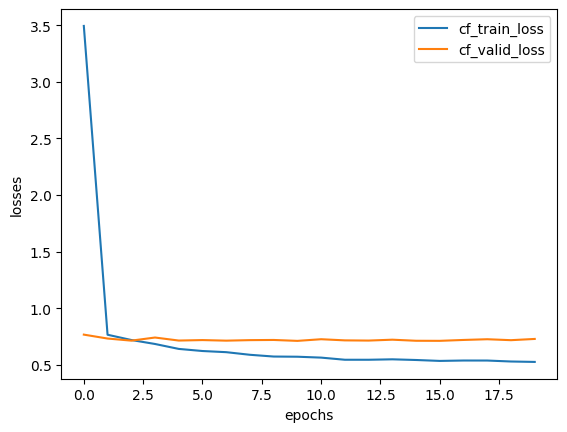

In [219]:
cf_train_loss = [3.4930, 0.7662, 0.7197, 0.6845, 0.6410, 0.6224, 0.6122, 0.5891, 0.5736, 0.5720,
                0.5641, 0.5453, 0.5452, 0.5491, 0.5431, 0.5350, 0.5385, 0.5383, 0.5298, 0.5261]
cf_valid_loss = [0.7672, 0.7326, 0.7140, 0.7415, 0.7148, 0.7190, 0.7139, 0.7185, 0.7200, 0.7119,
                0.7265, 0.7164, 0.7146, 0.7224, 0.7129, 0.7123, 0.7201, 0.7264, 0.7181, 0.7290]
x = [i for i in range(20)]
plt.plot(x, cf_train_loss, label = "cf_train_loss")
plt.plot(x, cf_valid_loss, label = "cf_valid_loss")
plt.xlabel("epochs")
plt.ylabel("losses")
plt.legend()
plt.show()

### For NeuMF model

#### model out text
Epoch 1/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m6s[0m 3ms/step - loss: 5.0168 - val_loss: 0.8081
Epoch 2/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m6s[0m 3ms/step - loss: 0.6364 - val_loss: 0.8080
Epoch 3/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m6s[0m 3ms/step - loss: 0.6093 - val_loss: 0.8073
Epoch 4/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m6s[0m 4ms/step - loss: 0.6091 - val_loss: 0.8240
Epoch 5/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m6s[0m 3ms/step - loss: 0.6016 - val_loss: 0.8063
Epoch 6/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m6s[0m 3ms/step - loss: 0.5926 - val_loss: 0.8141
Epoch 7/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m6s[0m 3ms/step - loss: 0.5982 - val_loss: 0.7956
Epoch 8/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m6s[0m 3ms/step - loss: 0.5928 - val_loss: 0.7977
Epoch 9/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m6s[0m 3ms/step - loss: 0.5828 - val_loss: 0.7971
Epoch 10/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m6s[0m 3ms/step - loss: 0.5865 - val_loss: 0.8086
Epoch 11/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m6s[0m 3ms/step - loss: 0.5739 - val_loss: 0.7912
Epoch 12/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m6s[0m 4ms/step - loss: 0.5832 - val_loss: 0.7928
Epoch 13/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m6s[0m 3ms/step - loss: 0.5780 - val_loss: 0.8138
Epoch 14/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m6s[0m 3ms/step - loss: 0.5718 - val_loss: 0.7975
Epoch 15/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m6s[0m 4ms/step - loss: 0.5734 - val_loss: 0.8029
Epoch 16/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m6s[0m 3ms/step - loss: 0.5705 - val_loss: 0.7961
Epoch 17/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m6s[0m 3ms/step - loss: 0.5663 - val_loss: 0.8052
Epoch 18/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m6s[0m 4ms/step - loss: 0.5778 - val_loss: 0.8101
Epoch 19/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m6s[0m 3ms/step - loss: 0.5734 - val_loss: 0.8048
Epoch 20/20
[1m1647/1647[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m6s[0m 4ms/step - loss: 0.5651 - val_loss: 0.7995


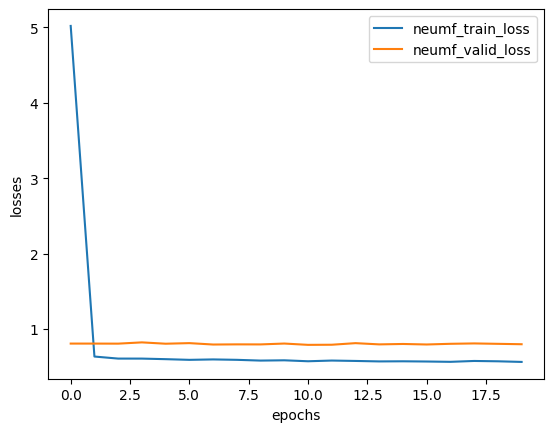

In [220]:
neumf_train_loss = [5.0168, 0.6364, 0.6093, 0.6091, 0.6016, 0.5926, 0.5982, 0.5928, 0.5828, 0.5865,
                    0.5739, 0.5832, 0.5780, 0.5718, 0.5734, 0.5705, 0.5663, 0.5778, 0.5734, 0.5651]
neumf_valid_loss = [0.8081, 0.8080, 0.8073, 0.8240, 0.8063, 0.8141, 0.7956, 0.7977, 0.7971, 0.8086, 
                    0.7912, 0.7928, 0.8138, 0.7975, 0.8029, 0.7961, 0.8052, 0.8101, 0.8048, 0.7995]
x = [i for i in range(20)]
plt.plot(x, neumf_train_loss, label = "neumf_train_loss")
plt.plot(x, neumf_valid_loss, label = "neumf_valid_loss")
plt.xlabel("epochs")
plt.ylabel("losses")
plt.legend()
plt.show()

In [243]:
model = tf.keras.models.load_model('models/model56_32_16_8.keras')
y_pred = model.predict([train_reviewers, train_products])
print("Train set RMSE: ", rmse(y_pred, train_ratings))
y_pred = model.predict([valid_reviewers, valid_products])
print("Validation set RMSE: ", rmse(y_pred, valid_ratings))

1647/1647 ━━━━━━━━━━━━━━━━━━━━ 1s 348us/step
Train set RMSE:  0.6789221881052284
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
Validation set RMSE:  0.8326316969979083
